# setwd

In [1]:
options(warn = -1)    
library(ggplot2)
library(reshape2)
library(Rmisc)
library(Hmisc)
library(EnhancedVolcano)
library(pracma)
library(car)
library(ggrepel)
library(edgeR)
#library(org.Mmu.eg.db)
library(grid)
library(gridExtra)
library(Mfuzz)
library(M3C)
library(preprocessCore)
library(rlist)
library(ggsci)
library(scales)
library(data.table)
library(RColorBrewer)
library(readxl)
setwd("E:/github/code_forpublication/macaca_multiple_tissue")
source('./subroutines.R')
source('./subroutines_for_MCMT_aging.R')

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: lattice

Loading required package: plyr

Loading required package: survival

Loading required package: Formula


Attaching package: 'Hmisc'


The following objects are masked from 'package:plyr':

    is.discrete, summarize


The following objects are masked from 'package:base':

    format.pval, units


Loading required package: ggrepel


Attaching package: 'pracma'


The following object is masked from 'package:Hmisc':

    ceil


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:pracma':

    logit


Loading required package: limma

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ

# read data

In [2]:
#whole body data
load('./data/pro.whole.fdr0.01_v20210108_from_NOVO_remap_solid_tissues.Rdata')# pro
load('./data/mrna.whole_v20210108_solid_tissues.Rdata')
load('./data/met_whole_from_novo_v20210108_solid_tissues.Rdata')

In [3]:
# tissue data
load('./data/pro.tissues_v20210108_solid_tissues.Rdata')
load('./data/mrna.tissues_v20210108_solid_tissues.Rdata')
load('./data/met.tissues_v20210108_solid_tissues.Rdata')
#remove list

In [4]:
load('./data/met.header.all.hmdb_curated.Rdata')
idx = !is.na(met.header.all.hmdb$hmdbid_highconfidence)
met.header.all.hmdb.v = met.header.all.hmdb[idx,]

# quality control

In [5]:
# protein remove outliners
tmp = pro.whole
pp = prcomp(t(tmp),cor=F)
#p = tsne(pro.whole.std,labels=tissue.systems[pro.whole.info$tissue_en],legendtextsize = 10,dotsize = 2)
outlinerids = c()
thetissues = unique(pro.whole.info$tissue_en)
for(i in 1:length(thetissues)){
    idx = pro.whole.info$tissue_en == thetissues[i]
    tmpinfo = pro.whole.info[idx,]
    outx = is.outliner(pp$x[idx,1])
    outy = is.outliner(pp$x[idx,2])
    #outy = is.outliner(pp$x[idx,2],coef = 3)
    if(sum(outx | outy) > 0){
        outlinerids = c(outlinerids,rownames(tmpinfo)[outx | outy])
    } 
}
outlinerids
vid = !is.element(colnames(pro.whole),outlinerids)
pro.whole = pro.whole[,vid]
pro.whole.info = pro.whole.info[vid,]

[1] "X06080_Skin_of_back"   "X11062_Pituitary"      "X94356_Liver"         
 [4] "X12092_Thyroid_gland"  "X06080_Thyroid_gland"  "X94356_Cecum"         
 [7] "X16002_Adrenal_gland"  "X92338_Adrenal_gland"  "X12390_Fallopian_tube"
[10] "X16068_Hypothalamus"   "X06070_Pancreas"       "X16086_Uterus"

In [6]:
# met remove outliners
tmp = met.whole
pp = prcomp(t(tmp),cor=F)
#p = tsne(met.whole.std,labels=tissue.systems[met.whole.info$tissue_en],legendtextsize = 10,dotsize = 2)
outlinerids = c()
thetissues = unique(met.whole.info$tissue_en)
for(i in 1:length(thetissues)){
    idx = met.whole.info$tissue_en == thetissues[i]
    tmpinfo = met.whole.info[idx,]
    outx = is.outliner(pp$x[idx,1])
    outy = is.outliner(pp$x[idx,2])
    #outy = is.outliner(pp$x[idx,2],coef = 3)
    if(sum(outx | outy) > 0){
        outlinerids = c(outlinerids,rownames(tmpinfo)[outx | outy])
    } 
}
outlinerids
vid = !is.element(colnames(met.whole),outlinerids)
met.whole = met.whole[,vid]
met.whole.info = met.whole.info[vid,]

NULL

In [7]:
# mrna remove outliners
tmp = mrna.whole
pp = prcomp(t(tmp),cor=F)
#p = tsne(mrna.whole.std,labels=tissue.systems[mrna.whole.info$tissue_en],legendtextsize = 10,dotsize = 2)
outlinerids = c()
thetissues = unique(mrna.whole.info$tissue_en)
for(i in 1:length(thetissues)){
    idx = mrna.whole.info$tissue_en == thetissues[i]
    tmpinfo = mrna.whole.info[idx,]
    outx = is.outliner(pp$x[idx,1])
    outy = is.outliner(pp$x[idx,2])
    #outy = is.outliner(pp$x[idx,2],coef = 3)
    if(sum(outx | outy) > 0){
        outlinerids = c(outlinerids,rownames(tmpinfo)[outx | outy])
    } 
}
outlinerids
vid = !is.element(colnames(mrna.whole),outlinerids)
mrna.whole = mrna.whole[,vid]
mrna.whole.info = mrna.whole.info[vid,]

NULL

# set colors

In [8]:
alltissues = names(pro.tissues)

tissue.systems = c('Integumentary','Endocrine','Brain','Respiratory','Digestive',
             'Cardiovascular','Cardiovascular','Brain','Digestive','Endocrine',
             'Cardiovascular','Muscle','Reproductive','Digestive','Brain',
             'Immune','Renal','Endocrine','Digestive','Reproductive',
             'Digestive','Brain','Muscle','Immune','Integumentary','Endocrine',
            'Brain','Immune','Cardiovascular','Reproductive')
names(tissue.systems) = alltissues
tissue.color = pal_npg()(10)
names(tissue.color) = levels(factor(tissue.systems))

In [9]:
tissue.systems
tissue.color

Skin_of_back               Pituitary            Frontal_pole 
        "Integumentary"             "Endocrine"                 "Brain" 
                   Lung                   Liver        Arteria_cruralis 
          "Respiratory"             "Digestive"        "Cardiovascular" 
           Femoral_vein             Hippocampus               Ileocecum 
       "Cardiovascular"                 "Brain"             "Digestive" 
          Thyroid_gland         Arteria_carotis                  Muscle 
            "Endocrine"        "Cardiovascular"                "Muscle" 
                  Ovary                   Cecum Superior_temporal_gyrus 
         "Reproductive"             "Digestive"                 "Brain" 
                 Spleen                  Kidney           Adrenal_gland 
               "Immune"                 "Renal"             "Endocrine" 
               Duodenum          Fallopian_tube                 Stomach 
            "Digestive"          "Reproductive"             "Digestive" 
           Hypothalamus                   Heart                  Thymus 
                "Brain"                "Muscle"                "Immune" 
            Facial_skin                Pancreas     Supramarginal_gyrus 
        "Integumentary"             "Endocrine"                 "Brain" 
                Adipose             Aortic_arch                  Uterus 
               "Immune"        "Cardiovascular"          "Reproductive"

Brain Cardiovascular      Digestive      Endocrine         Immune 
   "#E64B35FF"    "#4DBBD5FF"    "#00A087FF"    "#3C5488FF"    "#F39B7FFF" 
 Integumentary         Muscle          Renal   Reproductive    Respiratory 
   "#8491B4FF"    "#91D1C2FF"    "#DC0000FF"    "#7E6148FF"    "#B09C85FF"

[1] "#3B4992FF" "#EE0000FF" "#008B45FF" "#631879FF" "#008280FF" "#BB0021FF"
 [7] "#5F559BFF" "#A20056FF" "#808180FF" "#1B1919FF"

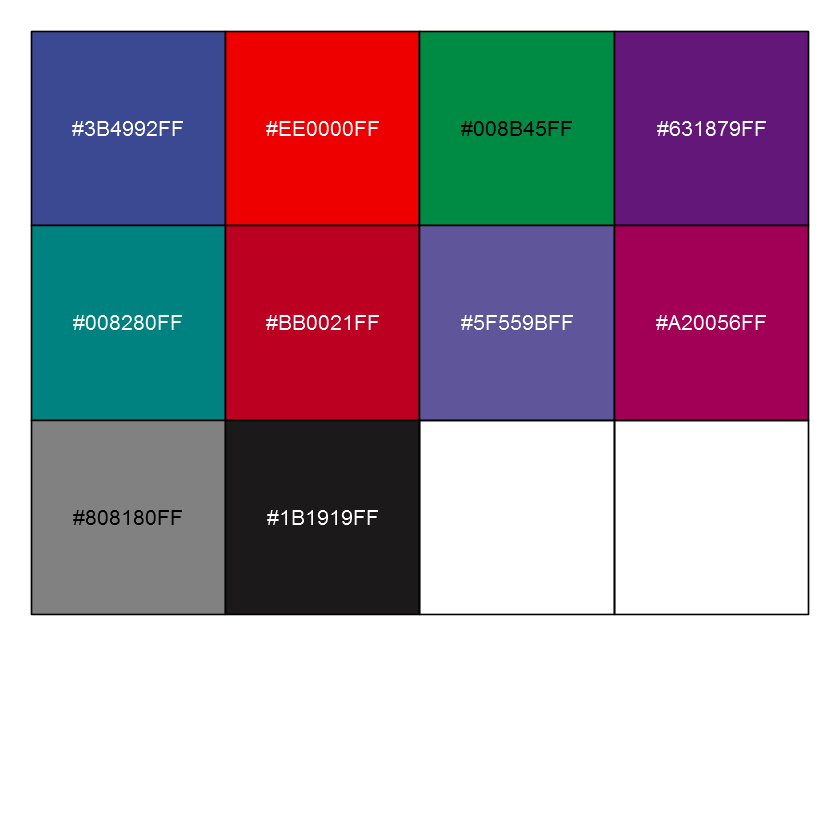

In [10]:
mypal = pal_aaas()(10)
mypal
show_col(mypal)

# Figure 1： overall data distribution

## Figure 1A flowchart

In [12]:
# flowchart

## Figure 1B

In [11]:
num_omics = data.frame(num_mrna = rep(0,length(alltissues)),stringsAsFactors = F,
                       tissues = alltissues,
                       tissue_systems = tissue.systems,
                      num_protein = rep(0,length(alltissues)),
                       num_met = rep(0,length(alltissues))
                       )
for(i in 1:length(alltissues)){
    num_omics$num_mrna[i] = nrow(mrna.tissues[[alltissues[i]]])
    num_omics$num_protein[i] = nrow(pro.tissues[[alltissues[i]]])
    num_omics$num_met[i] = nrow(met.tissues[[alltissues[i]]])
}
rownames(num_omics) = alltissues

In [13]:
idx = sort.int(num_omics$num_protein,decreasing = F,index.return = T)$ix
num_omics.v = num_omics[idx,]
idx = sort.int(num_omics.v$tissue_systems,decreasing = F,index.return = T)$ix
num_omics.v = num_omics.v[idx,]
writetxt(num_omics.v[,c(2,3,1,4,5)],'./out/20230217_aging/Figure1_Overall_data_distribution/Figure_1B_number_omics_data.txt')

In [14]:
idx = sort.int(num_omics$num_protein,decreasing = F,index.return = T)$ix
num_omics.v = num_omics[idx,]
idx = sort.int(num_omics.v$tissue_systems,decreasing = F,index.return = T)$ix
num_omics.v = num_omics.v[idx,]

pomics = list()
pomics[[1]] = ggplot(num_omics.v,aes(x = factor(tissues,level = tissues),y = num_met,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity")+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+ scale_color_npg()+scale_fill_npg()+ 
theme(axis.text.x=element_blank(),axis.title.x=element_blank())+ ylab('Number of metabolites')#+ylim(0,8200)


pomics[[2]] = ggplot(num_omics.v,aes(x = factor(tissues,level = tissues),y = num_protein,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity")+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+ scale_color_npg()+scale_fill_npg()+
theme(axis.text.x=element_blank(),axis.title.x=element_blank())+
ylab('Number of proteins')+ xlab('')#+ylim(0,8200)

pomics[[3]] = ggplot(num_omics.v,aes(x = factor(tissues,level = tissues),y = num_mrna,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity")+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_npg()+scale_fill_npg()+
ylab('Number of coding mRNAs')+ xlab('')#+ylim(0,8200)

pdf(file = './out/20230217_aging/Figure1_Overall_data_distribution/Figure1B_number_of_omics_mrna_pro_met.pdf',width = 12,height = 9)
grid.arrange(arrangeGrob(grobs = pomics,ncol = 1,heights = c(2.4,2.4,4.2)))
dev.off()

png 
  2

In [15]:
idx = sort.int(num_omics$num_protein,decreasing = F,index.return = T)$ix
num_omics.v = num_omics[idx,]
idx = sort.int(num_omics.v$tissue_systems,decreasing = F,index.return = T)$ix
num_omics.v = num_omics.v[idx,]

pomics = list()
pomics[[1]] = ggplot(num_omics.v,aes(x = factor(tissues,level = tissues),y = num_met,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity")+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 18)+ scale_color_npg()+scale_fill_npg()+ 
theme(axis.text.x=element_blank(),axis.title.x=element_blank())+ ylab('Number of metabolites')#+ylim(0,8200)


pomics[[2]] = ggplot(num_omics.v,aes(x = factor(tissues,level = tissues),y = num_protein,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity")+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 18)+ scale_color_npg()+scale_fill_npg()+
#theme(axis.text.x=element_blank(),axis.title.x=element_blank())+
ylab('Number of proteins')+ xlab('')#+ylim(0,8200)

pdf(file = './out/20230217_aging/Figure1_Overall_data_distribution/Figure1B_number_of_omicsV__promet.pdf',width = 12,height = 9)
grid.arrange(arrangeGrob(grobs = pomics,ncol = 1,heights = c(3.2,5.8)))
dev.off()

png 
  2

In [16]:
# total identified molecules
vmrna = c()
for (i in 1:length(mrna.tissues)){
    vmrna = unique(c(vmrna,rownames(mrna.tissues[[i]])))
}
length(vmrna)


vproteins = c()
for (i in 1:length(pro.tissues)){
    vproteins = unique(c(vproteins,pro.tissues.header[[i]]$Gene))
}
length(vproteins)

vmets = c()
for (i in 1:length(met.tissues)){
    vmets = unique(c(vmets,rownames(met.tissues[[i]])))
}
length(vmets)

[1] 16614

[1] 14295

[1] 5789

## Figure 1C-1E tsne

### mRNA

In [19]:
### for mRNA
mrna.whole.std = standardise_matrix(mrna.whole)

In [24]:
p = tsne(mrna.whole.std,labels=tissue.systems[mrna.whole.info$tissues],legendtextsize = 10,dotsize = 2)
p = p + theme_classic()+lghplot.addtheme(legend.position = 'none')+ scale_color_npg()+ xlab('tsne 1') + ylab('tsne 2')+
theme(axis.line = element_line(size = 1.0))
pdf(file ="./out/20230217_aging/Figure1_Overall_data_distribution/Figure1C_tSNE_mrna_using_standardised.pdf",height = 4,width = 4)
print(p)
dev.off()

Performing PCA
Read the 517 x 50 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 15.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.04 seconds (sparsity = 0.122586)!
Learning embedding...
Iteration 50: error is 60.393912 (50 iterations in 0.06 seconds)
Iteration 100: error is 53.693089 (50 iterations in 0.04 seconds)
Iteration 150: error is 52.086777 (50 iterations in 0.04 seconds)
Iteration 200: error is 51.372503 (50 iterations in 0.05 seconds)
Iteration 250: error is 50.987769 (50 iterations in 0.05 seconds)
Iteration 300: error is 0.498514 (50 iterations in 0.04 seconds)
Iteration 350: error is 0.394482 (50 iterations in 0.04 seconds)
Iteration 400: error is 0.375730 (50 iterations in 0.04 seconds)
Iteration 450: error is 0.364321 (50 iterations in 0.04 seconds)
Iteration 500: error is 0.357608 (50 iterations in 0.04 seconds)
Fitting performed in 0.44 seconds.


png 
  2

### protein

In [25]:
ida = rowSums(pro.whole < 0.1) < 0.2 * ncol(pro.whole)
sum(ida)
pro.whole.cons = pro.whole[ida,]
pro.whole.std = standardise_matrix(pro.whole.cons)

[1] 3087

In [28]:
p = tsne(pro.whole.std,labels=tissue.systems[pro.whole.info$tissue_en],legendtextsize = 10,dotsize = 2)
p = p + theme_classic()+lghplot.addtheme(legend.position = 'none')+ scale_color_npg()+ xlab('tsne 1') + ylab('tsne 2')
pdf(file ="./out/20230217_aging/Figure1_Overall_data_distribution/Figure1D_tSNE_protein_using_standardised.pdf",height = 4,width = 4)
print(p)
dev.off()

Performing PCA
Read the 469 x 50 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 15.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.04 seconds (sparsity = 0.140661)!
Learning embedding...
Iteration 50: error is 59.095186 (50 iterations in 0.04 seconds)
Iteration 100: error is 52.564921 (50 iterations in 0.04 seconds)
Iteration 150: error is 50.672942 (50 iterations in 0.03 seconds)
Iteration 200: error is 49.773074 (50 iterations in 0.04 seconds)
Iteration 250: error is 49.316013 (50 iterations in 0.03 seconds)
Iteration 300: error is 0.312997 (50 iterations in 0.03 seconds)
Iteration 350: error is 0.228908 (50 iterations in 0.03 seconds)
Iteration 400: error is 0.212332 (50 iterations in 0.03 seconds)
Iteration 450: error is 0.203496 (50 iterations in 0.03 seconds)
Iteration 500: error is 0.196968 (50 iterations in 0.03 seconds)
Fitting performed in 0.33 seconds.


png 
  2

In [29]:
graphics.off()

### metabolism

In [30]:
met.whole.std = standardise_matrix(met.whole)

In [32]:
p = tsne(met.whole.std,labels=tissue.systems[met.whole.info$Tissues],legendtextsize = 10,dotsize = 2)
p = p + theme_classic()+lghplot.addtheme(legend.position = 'none')+ scale_color_npg()+ xlab('tsne 1') + ylab('tsne 2')+
theme(axis.line = element_line(size = 1.0))
pdf(file ="./out/20230217_aging/Figure1_Overall_data_distribution/Figure1E_tSNE_met_using_std.pdf",height = 4,width = 4)
print(p)
dev.off()

Performing PCA
Read the 610 x 50 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 15.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.05 seconds (sparsity = 0.099731)!
Learning embedding...
Iteration 50: error is 68.156215 (50 iterations in 0.06 seconds)
Iteration 100: error is 61.354362 (50 iterations in 0.05 seconds)
Iteration 150: error is 60.481813 (50 iterations in 0.05 seconds)
Iteration 200: error is 60.199321 (50 iterations in 0.05 seconds)
Iteration 250: error is 60.068531 (50 iterations in 0.05 seconds)
Iteration 300: error is 0.776201 (50 iterations in 0.04 seconds)
Iteration 350: error is 0.626270 (50 iterations in 0.04 seconds)
Iteration 400: error is 0.593700 (50 iterations in 0.04 seconds)
Iteration 450: error is 0.576861 (50 iterations in 0.04 seconds)
Iteration 500: error is 0.570540 (50 iterations in 0.04 seconds)
Fitting performed in 0.46 seconds.


png 
  2

# Figure 2 tissue aging DEGs and GO

## protein 

In [12]:
DEproFC = list()
DEproPvalue = list()
DEproAging = list()
DEproFC.develop = list()
DEproPvalue.develop = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thispro = pro.tissues[[thistissue]]
    thispro.header = pro.tissues.header[[thistissue]]
    thispro = delete_dup_genes_forprotein(thispro,pro.tissues.header[[thistissue]])
    thispro.info = pro.tissues.info[[thistissue]]
    thisDEpro = DEGenes.simplified(thispro,catagory = thispro.info$stage == 4,
                               subset = thispro.info$stage == 4 | thispro.info$stage == 1)
    thisDEpro.develop = DEGenes.simplified(thispro,catagory = thispro.info$stage == 2,
                               subset = thispro.info$stage == 2 | thispro.info$stage == 1)
    forsort = thisDEpro$Pvalue
    forsort[is.na(forsort)] = 1
    idx = sort.int(forsort,decreasing = F,index.return = T)$ix
    DEproAging[[i]] = thisDEpro[idx,-5]
    DEproAging[[i]]$log2FC.devControl = thisDEpro.develop$log2FC
    DEproAging[[i]]$Pvalue.devControl = thisDEpro.develop$Pvalue
    
    DEproFC[[i]] = thisDEpro$log2FC
    names(DEproFC[[i]]) = rownames(thisDEpro)
    DEproPvalue[[i]] = thisDEpro$Pvalue
    names(DEproPvalue[[i]])  = rownames(thisDEpro)
    
    DEproFC.develop[[i]] = thisDEpro.develop$log2FC
    names(DEproFC.develop[[i]]) = rownames(thisDEpro.develop)
    DEproPvalue.develop[[i]] = thisDEpro.develop$Pvalue
    names(DEproPvalue.develop[[i]])  = rownames(thisDEpro.develop)
}
names(DEproAging) = alltissues
names(DEproFC) = alltissues
names(DEproPvalue) = alltissues
names(DEproFC.develop) = alltissues
names(DEproPvalue.develop) = alltissues

In [28]:
#xid = res2$Pvalue > 0.05 | abs(res2$log2FC) < 0.58 | res2$Pvalue.devControl < 0.05
plot_Volcano <- function(res2, title){
    

tmpup = res2$Pvalue
tmpup[is.na(tmpup)] = 1
tmpup[res2$log2FC < 0] = 1
sortid_up = sort.int(-log10(tmpup),decreasing = T,index.return = T)$ix
tmpid.up = res2$ID[sortid_up[1:5]]

tmpdown = res2$Pvalue
tmpdown[is.na(tmpdown)] = 1
tmpdown[res2$log2FC > 0] = 1
sortid_down = sort.int(-log10(tmpdown),decreasing = T,index.return = T)$ix
tmpid.down = res2$ID[sortid_down[1:5]]

vid = is.element(res2$ID,c(tmpid.up,tmpid.down))
tlab = res2$ID
tlab[!vid] = NA

keyvals <- rep('gray50', nrow(res2))
names(keyvals) <- rep('NS', nrow(res2))   

keyvals[which(res2$log2FC > 0.58 & res2$Pvalue < 0.05)] <- "Brown"    
names(keyvals)[which(res2$log2FC > 0.58 & res2$Pvalue < 0.05)] <- 'High'    

keyvals[which(res2$log2FC < -0.58 & res2$Pvalue < 0.05)] <- "darkblue"    
names(keyvals)[which(res2$log2FC < -0.58 & res2$Pvalue < 0.05)] <- 'Low'   


p = EnhancedVolcano(res2,
                        lab = tlab,
                        x = 'log2FC',
                        y = 'Pvalue',
                        caption = NULL,
                        title = title,
                        border = 'full',
                        titleLabSize = 12,
                        FCcutoff = 0.58,
                        cutoffLineWidth = F,
                        axisLabSize = 12,
                        subtitle = NULL,
                        cutoffLineCol = 'white',
                        gridlines.minor = F,
                        gridlines.major = F,
                        xlab = bquote(~Log[2]~ 'fold change'),
                        pCutoff = 0.05,
                        colCustom = keyvals,
                        colAlpha = 4/5,
                        legendPosition = 'none',
                        legendLabSize = 5,
                        legendIconSize = 3,
                        drawConnectors = TRUE,
                        widthConnectors = 0.5,
                        transcriptPointSize = -0.3*log10(res2$Pvalue),transcriptLabSize = 3,
                        colConnectors = 'black')
    return(p)
    }



#tlab[sortid_up[6:length(sortid_up)]] = NA



In [ ]:
res2$log2FC

In [29]:
proteinVoconoPlot = list()
names.DEproAging = names(DEproAging)
for(i in 1:length(DEproAging)){
    res2 = DEproAging[[i]]
    
    proteinVoconoPlot[[i]] = plot_Volcano(res2,names.DEproAging[i])
}

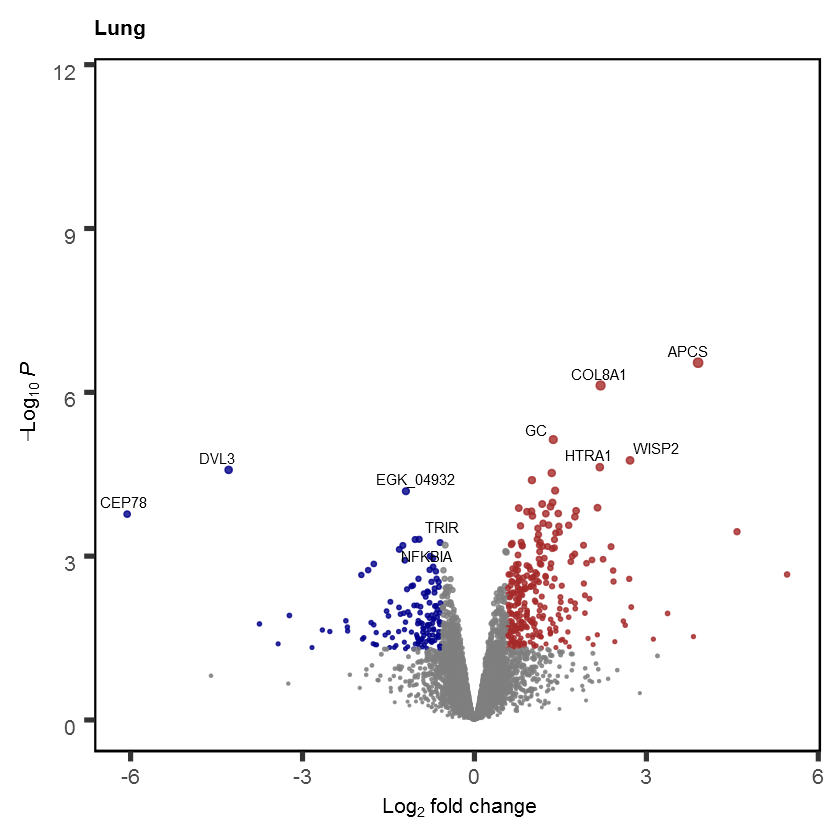

In [30]:
plot(proteinVoconoPlot[[4]])

In [19]:
graphics.off()

In [31]:
pdf(file = './out/20230217_aging/Figure2_DEG_GO_tissue/Figure2A_DEpro_each_tissueV1.pdf',width = 3*5+1,height =3*6)
grid.arrange(arrangeGrob(grobs = proteinVoconoPlot,ncol = 5))
dev.off()

png 
  2

In [55]:
#Data S2
openxlsx::write.xlsx(DEproAging, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S2_DE_tissue_Aging_pro.xlsx")

In [27]:
# reducce size Data S2
tpath = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S2_DE_tissue_Aging_pro.xlsx"
sheetNames = openxlsx::getSheetNames(tpath)
xx = list()
for(i in 1:length(sheetNames)){
    tmp = openxlsx::read.xlsx(tpath,sheet = sheetNames[i])
    tmp[c(2,3,4,7,8)] = signif(tmp[c(2,3,4,7,8)],3)
    tmp = tmp[,-c(5,6)]
    xx[[i]] = tmp
}
names(xx) = sheetNames
openxlsx::write.xlsx(xx, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/reduce_Data S2_DE_tissue_Aging_pro.xlsx")

#openxlsx::write.xlsx(DEproAging, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S2_DE_tissue_Aging_pro.xlsx")

In [56]:
list_to_matrix <- function(DEproFC,alltissues){
    DEproFC_matrix = list()
    for(i in 1:length(alltissues)){
        tmp = matrix(DEproFC[[i]],1,length(DEproFC[[i]]))
        tmp = as.data.frame(tmp)
        colnames(tmp) = names(DEproFC[[i]])
        DEproFC_matrix[[i]] = tmp
    }
    DEproFC_matrix = t(as.matrix(rbindlist(DEproFC_matrix,fill = T)))
    colnames(DEproFC_matrix) = names(DEproFC)
    #vid = rowSums(is.na(DEproFC_matrix)) < ncol(DEproFC_matrix)/2
    #DEproFC_matrix = DEproFC_matrix[vid,]
    return(DEproFC_matrix)
}
DEproFC_matrix = list_to_matrix(DEproFC,alltissues)
DEproPvalue_matrix = list_to_matrix(DEproPvalue,alltissues)

DEproFC_matrix.develop = list_to_matrix(DEproFC.develop,alltissues)
DEproPvalue_matrix.develop = list_to_matrix(DEproPvalue.develop,alltissues)


In [66]:
Aging_pro_sigup_matrix = (DEproFC_matrix > 0.58 & DEproPvalue_matrix < 0.05  & DEproPvalue_matrix.develop > 0.05) +0
Aging_pro_sigdown_matrix = -((DEproFC_matrix < -0.58 & DEproPvalue_matrix < 0.05 & DEproPvalue_matrix.develop > 0.05) +0)
Aging_pro_sigall_matrix = Aging_pro_sigup_matrix + Aging_pro_sigdown_matrix

In [67]:
Aging_pro_updown = data.frame(stringsAsFactors = F,num.up = colSums(Aging_pro_sigup_matrix,na.rm =T)/colSums(!is.na(Aging_pro_sigup_matrix)),
                              num.down = colSums(Aging_pro_sigdown_matrix,na.rm =T)/colSums(!is.na(Aging_pro_sigdown_matrix)),
                              num.all = colSums(abs(Aging_pro_sigall_matrix),na.rm =T)/colSums(!is.na(Aging_pro_sigall_matrix)),
                             tissues = colnames(Aging_pro_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(Aging_pro_updown) = Aging_pro_updown$tissues

In [117]:
Aging_pro_updown

,num.up,num.down,num.all,tissues,tissue_systems
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Skin_of_back,0.036514823,-0.02422270,0.06081448,Skin_of_back,Integumentary
Pituitary,0.024935277,-0.02820548,0.05316973,Pituitary,Endocrine
Frontal_pole,0.022538363,-0.01742606,0.03996803,Frontal_pole,Brain
Lung,0.033295982,-0.01888302,0.05220176,Lung,Respiratory
Liver,0.034220532,-0.01801802,0.05225225,Liver,Digestive
Arteria_cruralis,0.025117739,-0.04575335,0.07101526,Arteria_cruralis,Cardiovascular
Femoral_vein,0.041103448,-0.03337010,0.07450331,Femoral_vein,Cardiovascular
Hippocampus,0.013891271,-0.02023320,0.03413379,Hippocampus,Brain
Ileocecum,0.021394879,-0.04090909,0.06238408,Ileocecum,Digestive


In [68]:
mean(Aging_pro_updown$num.all)

[1] 0.07529843

## mRNA

In [32]:
DEmrnaFC = list()
DEmrnaPvalue = list()
DEmrnaAging = list()
DEmrnaFC.develop = list()
DEmrnaPvalue.develop = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismrna = mrna.tissues[[thistissue]]
    #thismrna.header = mrna.tissues.header[[thistissue]]
    thismrna.info = mrna.tissues.info[[thistissue]]
    if (sum(thismrna.info$stage == 1) ==1){ 
        thismrna = cbind(thismrna[,thismrna.info$stage == 1],thismrna)
        thismrna.info = rbind(thismrna.info[thismrna.info$stage == 1,],thismrna.info)
    }
    if (sum(thismrna.info$stage == 4) ==1){ 
        thismrna = cbind(thismrna,thismrna[,thismrna.info$stage == 4])
        thismrna.info = rbind(thismrna.info,thismrna.info[thismrna.info$stage == 4,])
    }
    
    thisDEmrna = DEGenes.simplified(thismrna,catagory = thismrna.info$stage == 4,
                               subset = thismrna.info$stage == 4 | thismrna.info$stage == 1)
    
    thisDEmrna.develop = DEGenes.simplified(thismrna,catagory = thismrna.info$stage == 2,
                               subset = thismrna.info$stage == 2 | thismrna.info$stage == 1)
    
    idx = sort.int(thisDEmrna$Pvalue,decreasing = F,index.return = T)$ix
    DEmrnaAging[[i]] = thisDEmrna[idx,-5]
    DEmrnaAging[[i]]$log2FC.devControl = thisDEmrna.develop$log2FC
    DEmrnaAging[[i]]$Pvalue.devControl = thisDEmrna.develop$Pvalue
    
    
    DEmrnaFC[[i]] = thisDEmrna$log2FC
    names(DEmrnaFC[[i]]) = rownames(thisDEmrna)
    DEmrnaPvalue[[i]] = thisDEmrna$Pvalue
    names(DEmrnaPvalue[[i]])  = rownames(thisDEmrna)
    
    DEmrnaFC.develop[[i]] = thisDEmrna.develop$log2FC
    names(DEmrnaFC.develop[[i]]) = rownames(thisDEmrna.develop)
    DEmrnaPvalue.develop[[i]] = thisDEmrna.develop$Pvalue
    names(DEmrnaPvalue.develop[[i]])  = rownames(thisDEmrna.develop)
    
    
}
names(DEmrnaFC) = alltissues
names(DEmrnaPvalue) = alltissues
names(DEmrnaAging) = alltissues
names(DEmrnaFC.develop) = alltissues
names(DEmrnaPvalue.develop) = alltissues



DEmrnaFC_matrix = list_to_matrix(DEmrnaFC,alltissues)
DEmrnaPvalue_matrix = list_to_matrix(DEmrnaPvalue,alltissues)

DEmrnaFC_matrix.develop = list_to_matrix(DEmrnaFC.develop,alltissues)
DEmrnaPvalue_matrix.develop = list_to_matrix(DEmrnaPvalue.develop,alltissues)

ERROR: Error in list_to_matrix(DEmrnaFC, alltissues): 参数没有用(alltissues)


In [70]:
# write Data S1
openxlsx::write.xlsx(DEmrnaAging, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S1_DE_tissue_Aging_mRNA.xlsx")

In [28]:
# reducce size Data S2
tpath = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S1_DE_tissue_Aging_mRNA.xlsx"
sheetNames = openxlsx::getSheetNames(tpath)
xx = list()
for(i in 1:length(sheetNames)){
    tmp = openxlsx::read.xlsx(tpath,sheet = sheetNames[i])
    tmp[c(2,3,4,7,8)] = signif(tmp[c(2,3,4,7,8)],3)
    tmp = tmp[,-c(5,6)]
    xx[[i]] = tmp
}
names(xx) = sheetNames
openxlsx::write.xlsx(xx, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/reduce_Data S1_DE_tissue_Aging_mRNA.xlsx")

In [79]:
Aging_mrna_sigup_matrix = (DEmrnaFC_matrix > 0.58 & DEmrnaPvalue_matrix < 0.05 & DEmrnaPvalue_matrix.develop > 0.05) +0
Aging_mrna_sigdown_matrix = -((DEmrnaFC_matrix < -0.58 & DEmrnaPvalue_matrix < 0.05 & DEmrnaPvalue_matrix.develop > 0.05) +0)
Aging_mrna_sigall_matrix = Aging_mrna_sigup_matrix + Aging_mrna_sigdown_matrix

Aging_mrna_updown = data.frame(stringsAsFactors = F,num.up = colSums(Aging_mrna_sigup_matrix,na.rm =T)/colSums(!is.na(Aging_mrna_sigup_matrix)),
                              num.down = colSums(Aging_mrna_sigdown_matrix,na.rm =T)/colSums(!is.na(Aging_mrna_sigdown_matrix)),
                              num.all = colSums(abs(Aging_mrna_sigall_matrix),na.rm =T)/colSums(!is.na(Aging_mrna_sigall_matrix)),
                             tissues = colnames(Aging_mrna_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(Aging_mrna_updown) = Aging_mrna_updown$tissues

In [80]:
mean(Aging_mrna_updown$num.all)

[1] 0.04937392

In [33]:
mrnaVoconoPlot = list()
names.DEmrnaAging = names(DEmrnaAging)
for(i in 1:length(DEmrnaAging)){
    res2 = DEmrnaAging[[i]]
    
    mrnaVoconoPlot[[i]] = plot_Volcano(res2,names.DEmrnaAging[i])
}

In [34]:
pdf(file = './out/20230217_aging/Figure2_DEG_GO_tissue/FigureS2B_DEmrna_each_tissueV1.pdf',width = 3*5+1,height =3*6)
grid.arrange(arrangeGrob(grobs = mrnaVoconoPlot,ncol = 5))
dev.off()

png 
  2

## metabolism

In [35]:
DEmetFC = list()
DEmetPvalue = list()
DEmetAging = list()
DEmetFC.develop = list()
DEmetPvalue.develop = list()
for(i in 1:length(alltissues)){
    #Mfuzz
    thistissue = alltissues[i]
    thismet = met.tissues[[thistissue]]
    thismet.header = met.tissues.header[[thistissue]]
    thismet.info = met.tissues.info[[thistissue]]
    if (sum(thismet.info$stage == 1) ==1){ 
        thismet = cbind(thismet[,thismet.info$stage == 1],thismet)
        thismet.info = rbind(thismet.info[thismet.info$stage == 1,],thismet.info)
    }
    if (sum(thismet.info$stage == 4) ==1){ 
        thismet = cbind(thismet,thismet[,thismet.info$stage == 4])
        thismet.info = rbind(thismet.info,thismet.info[thismet.info$stage == 4,])
    }
    
    thisDEmet = DEGenes.simplified(thismet,catagory = thismet.info$stage == 4,
                               subset = thismet.info$stage == 4 | thismet.info$stage == 1)
    
    thisDEmet.develop = DEGenes.simplified(thismet,catagory = thismet.info$stage == 2,
                               subset = thismet.info$stage == 2 | thismet.info$stage == 1)
    
    forsort = thisDEmet$Pvalue
    forsort[is.na(forsort)] = 1
    idx = sort.int(forsort,decreasing = F,index.return = T)$ix
    DEmetAging[[i]] = thisDEmet[idx,-5]
    DEmetAging[[i]]$log2FC.devControl = thisDEmet.develop$log2FC
    DEmetAging[[i]]$Pvalue.devControl = thisDEmet.develop$Pvalue
    
    DEmetFC[[i]] = thisDEmet$log2FC
    names(DEmetFC[[i]]) = rownames(thisDEmet)
    DEmetPvalue[[i]] = thisDEmet$Pvalue
    names(DEmetPvalue[[i]])  = rownames(thisDEmet)
    
    DEmetFC.develop[[i]] = thisDEmet.develop$log2FC
    names(DEmetFC.develop[[i]]) = rownames(thisDEmet.develop)
    DEmetPvalue.develop[[i]] = thisDEmet.develop$Pvalue
    names(DEmetPvalue.develop[[i]])  = rownames(thisDEmet.develop)
    
    
}
names(DEmetAging) = alltissues
names(DEmetFC) = alltissues
names(DEmetPvalue) = alltissues
DEmetFC_matrix = list_to_matrix(DEmetFC,alltissues)
DEmetPvalue_matrix = list_to_matrix(DEmetPvalue,alltissues)

DEmetFC_matrix.develop = list_to_matrix(DEmetFC.develop,alltissues)
DEmetPvalue_matrix.develop = list_to_matrix(DEmetPvalue.develop,alltissues)

ERROR: Error in list_to_matrix(DEmetFC, alltissues): 参数没有用(alltissues)


In [82]:
#write Data S3
openxlsx::write.xlsx(DEmetAging, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S3_DE_tissue_Aging_metabolite.xlsx")

In [29]:
# reducce size Data S2
tpath = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S3_DE_tissue_Aging_metabolite.xlsx"
sheetNames = openxlsx::getSheetNames(tpath)
xx = list()
for(i in 1:length(sheetNames)){
    tmp = openxlsx::read.xlsx(tpath,sheet = sheetNames[i])
    tmp[c(2,3,4,7,8)] = signif(tmp[c(2,3,4,7,8)],3)
    tmp = tmp[,-c(5,6)]
    xx[[i]] = tmp
}
names(xx) = sheetNames
openxlsx::write.xlsx(xx, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/reduce_Data S3_DE_tissue_Aging_metabolite.xlsx")

In [95]:
Aging_met_sigup_matrix = (DEmetFC_matrix > 0.58 & DEmetPvalue_matrix < 0.05   & DEmetPvalue_matrix.develop > 0.05) + 0
Aging_met_sigdown_matrix = -((DEmetFC_matrix < -0.58 & DEmetPvalue_matrix < 0.05   & DEmetPvalue_matrix.develop > 0.05) + 0)
Aging_met_sigall_matrix = Aging_met_sigup_matrix + Aging_met_sigdown_matrix

In [96]:
Aging_met_updown = data.frame(stringsAsFactors = F,num.up = colSums(Aging_met_sigup_matrix,na.rm =T)/colSums(!is.na(Aging_met_sigup_matrix)),
                              num.down = colSums(Aging_met_sigdown_matrix,na.rm =T)/colSums(!is.na(Aging_met_sigdown_matrix)),
                              num.all = colSums(abs(Aging_met_sigall_matrix),na.rm =T)/colSums(!is.na(Aging_met_sigall_matrix)),
                             tissues = colnames(Aging_met_sigup_matrix),
                             tissue_systems = tissue.systems)
rownames(Aging_met_updown) = Aging_met_updown$tissues

mean(Aging_met_updown$num.all)

[1] 0.07502263

In [36]:
metVoconoPlot = list()
names.DEmetAging = names(DEmetAging)
for(i in 1:length(DEmetAging)){
    res2 = DEmetAging[[i]]
    
    metVoconoPlot[[i]] = plot_Volcano(res2,names.DEmetAging[i])
}

In [37]:
pdf(file = './out/20230217_aging/Figure2_DEG_GO_tissue/FigureS2C_DEmet_each_tissueV1.pdf',width = 3*5+1,height =3*6)
grid.arrange(arrangeGrob(grobs = metVoconoPlot,ncol = 5))
dev.off()

png 
  2

In [118]:
Aging_met_updown

,num.up,num.down,num.all,tissues,tissue_systems
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Skin_of_back,0.036030341,-0.027180784,0.06321113,Skin_of_back,Integumentary
Pituitary,0.127226463,-0.078032231,0.20525869,Pituitary,Endocrine
Frontal_pole,0.013303769,-0.047302291,0.06060606,Frontal_pole,Brain
Lung,0.015033073,-0.021046302,0.03607937,Lung,Respiratory
Liver,0.006362059,-0.029496819,0.03585888,Liver,Digestive
Arteria_cruralis,0.020116807,-0.020765737,0.04088254,Arteria_cruralis,Cardiovascular
Femoral_vein,0.000000000,-0.011150235,0.01115023,Femoral_vein,Cardiovascular
Hippocampus,0.014792899,-0.015532544,0.03032544,Hippocampus,Brain
Ileocecum,0.012651265,-0.058305831,0.07095710,Ileocecum,Digestive


In [148]:
met.class_enrichment <- function(mets,annote){
  require(clusterProfiler)

  vmet = intersect(mets,rownames(annote))
  fluxgmt = data.frame(ont = annote$sub_class,gene = rownames(annote),stringsAsFactors = F) 
  
  Recon3D <- enricher(gene = vmet,
                TERM2GENE=fluxgmt,
                pAdjustMethod = "BH",
                minGSSize = 1,
                pvalueCutoff =1,
                qvalueCutoff = 1
                )
  Recon3Dout = Recon3D@result
  Recon3Dout$DB = rep('HMDBclass',dim(Recon3Dout)[1])
  n = dim(Recon3Dout)[2]
  Recon3Dout = Recon3Dout[,c(n,1:(n-1))]
  return(Recon3Dout)
}

In [149]:
tmpid = sort.int(rowSums(Aging_met_sigall_matrix,na.rm = T),decreasing = T,index.return = T)$ix
top20up = rownames(Aging_met_sigall_matrix)[tmpid[1:30]]
tmpid = sort.int(rowSums(Aging_met_sigall_matrix,na.rm = T),decreasing = F,index.return = T)$ix
top20down = rownames(Aging_met_sigall_matrix)[tmpid[1:30]]
xx = Aging_met_sigall_matrix[c(top20up,top20down),]
xx[is.na(xx)] = 0

#pheatmap::pheatmap(xx,cluster_rows = T,fontsize_row = 5,
#                   color=colorRampPalette(c('#3B4992','gray95','#BB0021'))(10))

## Figure 2A perc changed mols each tissue

In [99]:
fmt_dcimals <- function(decimals=0){
    function(x) format(x,nsmall = decimals,scientific = FALSE)
}

In [821]:
plotAgingNum = list()
idx = sort.int(Aging_pro_updown$num.all,decreasing = F,index.return = T)$ix
Aging_pro_updown.v = Aging_pro_updown[idx,]
idx = sort.int(Aging_pro_updown.v$tissue_systems,decreasing = F,index.return = T)$ix
Aging_pro_updown.v = Aging_pro_updown.v[idx,]
tissueindex = rownames(Aging_pro_updown.v)
Aging_met_updown.v = Aging_met_updown[tissueindex,]

p1 = ggplot(Aging_met_updown.v,aes(x = factor(tissues,level = tissues),y = num.up,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity",alpha = 0.8)#+
#theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
#theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas()+
#scale_fill_aaas()+
#ylab('Number of coding mRNAs')+ xlab('')#+ylim(0,8200)
plotAgingNum[[1]] = p1+ geom_bar(stat="identity",aes(y = num.down),alpha = 0.6)+geom_hline(yintercept = 0)+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas(alpha = 0.6)+
scale_fill_aaas(alpha = 0.6)+theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),axis.line.x =element_blank())+
scale_y_continuous(labels = fmt_dcimals(2))+
ylab('Metabolites')+ xlab('')#+ylim(0,8200)

In [822]:

#idx = sort.int(Aging_pro_updown$num.all,decreasing = F,index.return = T)$ix
#Aging_pro_updown.v = Aging_pro_updown[idx,]
#idx = sort.int(Aging_pro_updown.v$tissue_systems,decreasing = F,index.return = T)$ix
Aging_pro_updown.v = Aging_pro_updown[tissueindex,]

p1 = ggplot(Aging_pro_updown.v,aes(x = factor(tissues,level = tissues),y = num.up,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity",alpha = 0.8)#+
#theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
#theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas()+
#scale_fill_aaas()+
#ylab('Number of coding mRNAs')+ xlab('')#+ylim(0,8200)
plotAgingNum[[2]] = p1+ geom_bar(stat="identity",aes(y = num.down),alpha = 0.6)+geom_hline(yintercept = 0)+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas(alpha = 0.6)+
scale_fill_aaas(alpha = 0.6)+  
#theme(axis.ticks.x = element_blank(),axis.text.x = element_blank(),axis.line.x =element_blank())+
scale_y_continuous(labels = fmt_dcimals(2))+
ylab('Proteins')+ xlab('')#+ylim(0,8200)+scale_y_log10

In [111]:
#idx = sort.int(Aging_mrna_updown$num.all,decreasing = F,index.return = T)$ix
#Aging_mrna_updown.v = Aging_mrna_updown[idx,]
#idx = sort.int(Aging_mrna_updown.v$tissue_systems,decreasing = F,index.return = T)$ix
Aging_mrna_updown.v = Aging_mrna_updown[tissueindex,]

p1 = ggplot(Aging_mrna_updown.v,aes(x = factor(tissues,level = tissues),y = num.up,
                       color = tissue_systems,fill = tissue_systems))+ geom_bar(stat="identity",alpha = 0.8)#+
#theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
#theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas()+
#scale_fill_aaas()+
#ylab('Number of coding mRNAs')+ xlab('')#+ylim(0,8200)
plotAgingNum[[3]] = p1+ geom_bar(stat="identity",aes(y = num.down),alpha = 0.6)+geom_hline(yintercept = 0)+
theme_classic()+lghplot.addtheme(legend.position = 'none',hjust = 1,size = 13.5)+
theme(axis.text.y = element_text(size = 9.5, face = "bold", color = "black"))+scale_color_aaas(alpha = 0.6)+
scale_fill_aaas(alpha = 0.6)+scale_y_continuous(labels = fmt_dcimals(2))+
ylab('mRNAs')+ xlab('')#+ylim(0,8200)

In [823]:
pdf(file = './out/20230217_aging/Figure2_DEG_GO_tissue/Figure2A_number_of_Aging_moleculars_prometv1_aaas.pdf',width = 12,height =5)
grid.arrange(arrangeGrob(grobs = plotAgingNum,ncol = 1,heights = c(1.7,3.3)))
dev.off()

png 
  2

In [67]:
pdf(file = './out/20230217_aging/Figure2_DEG_GO_tissue/Figure2A_number_of_Aging_molecularsv1.pdf',width = 12,height = 9)
grid.arrange(arrangeGrob(grobs = plotAgingNum,ncol = 1,heights = c(2.4,2.4,4.2)))
dev.off()

png 
  2

## Figure 2B enrichment

### protein

In [133]:
#write for metascape up
inputGOenrich = data.frame(tissues = names(DEproAging),stringsAsFactors = F,
                      genes = rep('c',length(DEproAging)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEproAging)){
    tmp = DEproAging[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC > 0.58 & tmp$Pvalue.devControl > 0.05])
    tgenes = tgenes[!is.na(tgenes)]
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20230217_aging/Figure2_DEG_GO_tissue/protein/_inputGOenrich_age_DEpro_up.txt',row.names = F,col.names = F)

In [134]:
#write for metascape down
inputGOenrich = data.frame(tissues = names(DEproAging),stringsAsFactors = F,
                      genes = rep('c',length(DEproAging)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEproAging)){
    tmp = DEproAging[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC < -0.58 & tmp$Pvalue.devControl > 0.05])
    tgenes = tgenes[!is.na(tgenes)]
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20230217_aging/Figure2_DEG_GO_tissue/protein/_inputGOenrich_age_DEpro_down.txt',row.names = F,col.names = F)

In [827]:
outids = c()
tpath1 = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = './out/20230217_aging/Figure2_DEG_GO_tissue/protein//metascape_DEpro_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
selectGO = readxl::read_xlsx(path = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_up/metascape_result.xlsx',sheet = 'Enrichment')
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)
rownames(go1) = paste0(go1$GO,'-',rownames(go1))
go1term = go1$GO
tpath1a = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_up/Enrichment_GO/GO_AllLists.csv'
go1qval = file2frame(tpath1a,sep = ',',header = T)
rownames(go1qval) = paste0(go1qval$GO,'X_LogP_',go1qval$GeneList)
go1 = abs(as.matrix(go1[,-1]))
cname = colnames(go1)
for(i in 1:nrow(go1)){
    for(j in 1:ncol(go1)){
        tmpname = paste0(go1term[i],cname[j])
        go1[i,j] = abs(go1qval[tmpname,]$Log.q.value.)
    }
}
go1[is.na(go1)] = 0

go1for_write = cbind(data.frame(GO = rownames(go1)),-go1)
outlist = list()
outlist[[1]] = go1for_write;
outlist[[2]] = selectGO;
tmpnames = sort(unique(go1qval$GeneList))
for(i in 1:length(tmpnames)){
    outlist[[i+2]] = go1qval[go1qval$GeneList == tmpnames[[i]],]
}
names(outlist) = c('GOenrichmentALL','selectGO',tmpnames)
openxlsx::write.xlsx(outlist, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S4_GO_tissue_upregulated_protein.xlsx")


selectGO = readxl::read_xlsx(path = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_down/metascape_result.xlsx',sheet = 'Enrichment')
go2 = file2frame(tpath2,sep = ',',header = T,row.names =2)
rownames(go2) = paste0(go2$GO,'-',rownames(go2))
go2term = go2$GO
tpath2a = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_down/Enrichment_GO/GO_AllLists.csv'
go2qval = file2frame(tpath2a,sep = ',',header = T)
rownames(go2qval) = paste0(go2qval$GO,'X_LogP_',go2qval$GeneList)
go2 = abs(as.matrix(go2[,-1]))
cname = colnames(go2)
for(i in 1:nrow(go2)){
    for(j in 1:ncol(go2)){
        tmpname = paste0(go2term[i],cname[j])
        go2[i,j] = -abs(go2qval[tmpname,]$Log.q.value.)
    }
}
go2[is.na(go2)] = 0

go1for_write = cbind(data.frame(GO = rownames(go2)),go2)
outlist = list()
outlist[[1]] = go1for_write;
outlist[[2]] = selectGO;
tmpnames = sort(unique(go2qval$GeneList))
for(i in 1:length(tmpnames)){
    outlist[[i+2]] = go2qval[go2qval$GeneList == tmpnames[[i]],]
}
names(outlist) = c('GOenrichmentALL','selectGO',tmpnames)
openxlsx::write.xlsx(outlist, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S5_GO_tissue_downregulated_protein.xlsx")


thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))
thisgo.matrix[abs(thisgo.matrix) < -log10(0.05)] = 0
writetxt(thisgo.matrix,'./out/20230217_aging/Figure2_DEG_GO_tissue/Figure2_heatmap_GOenrichment_metascape_DEpro_eachtissue_fdr.txt',row.names = T)
thisgo.matrix[thisgo.matrix > 4] = 4
thisgo.matrix[thisgo.matrix < -4] = -4

rownames(thisgo.matrix)[rownames(thisgo.matrix) == 'R-HSA-9716542-Signaling by Rho GTPases, Miro GTPases and RHOBTB3'] = 'R-HSA-9716542-Signaling by Rho GTPases'
rownames(thisgo.matrix)[rownames(thisgo.matrix) == 'R-HSA-1428517-The citric acid (TCA) cycle and respiratory electron transport'] = 'R-HSA-1428517-TCA cycle and respiratory electron transport'

graphics.off()
pheatmap::pheatmap(thisgo.matrix,cluster_rows = T,cluster_cols = T,fontsize_row = 11,fontsize_col = 11,fontsize = 14,treeheight_row = 20,treeheight_col = 20,legend = T,
                  color=colorRampPalette(c('#3B4992','gray99','#BB0021FF'))(50),
                  height = 10,width = 10,
                  file ="./out/20230217_aging/Figure2_DEG_GO_tissue/Figure2_heatmap_GOenrichment_metascape_DEpro_eachtissue.v1_aaas.pdf"
                   )

In [826]:
rownames(thisgo.matrix)

[1] "WP3888-VEGFA-VEGFR2 signaling pathway"                                       
 [2] "GO:0060627-regulation of vesicle-mediated transport"                         
 [3] "GO:0030029-actin filament-based process"                                     
 [4] "GO:0051129-negative regulation of cellular component organization"           
 [5] "hsa04510-Focal adhesion"                                                     
 [6] "GO:0051493-regulation of cytoskeleton organization"                          
 [7] "GO:0031344-regulation of cell projection organization"                       
 [8] "GO:0031175-neuron projection development"                                    
 [9] "GO:0032787-monocarboxylic acid metabolic process"                            
[10] "R-HSA-5653656-Vesicle-mediated transport"                                    
[11] "GO:0010035-response to inorganic substance"                                  
[12] "R-HSA-6798695-Neutrophil degranulation"                                      
[13] "GO:0043086-negative regulation of catalytic activity"                        
[14] "R-HSA-109582-Hemostasis"                                                     
[15] "hsa04610-Complement and coagulation cascades"                                
[16] "M5885-NABA MATRISOME ASSOCIATED"                                             
[17] "GO:0009611-response to wounding"                                             
[18] "GO:0031589-cell-substrate adhesion"                                          
[19] "R-HSA-1474244-Extracellular matrix organization"                             
[20] "M5884-NABA CORE MATRISOME"                                                   
[21] "R-HSA-199991-Membrane Trafficking"                                           
[22] "GO:0006886-intracellular protein transport"                                  
[23] "R-HSA-9716542-Signaling by Rho GTPases, Miro GTPases and RHOBTB3"            
[24] "R-HSA-2262752-Cellular responses to stress"                                  
[25] "R-HSA-72766-Translation"                                                     
[26] "R-HSA-162906-HIV Infection"                                                  
[27] "GO:1903311-regulation of mRNA metabolic process"                             
[28] "R-HSA-1640170-Cell Cycle"                                                    
[29] "GO:0051052-regulation of DNA metabolic process"                              
[30] "GO:0006974-cellular response to DNA damage stimulus"                         
[31] "GO:0006325-chromatin organization"                                           
[32] "GO:0032774-RNA biosynthetic process"                                         
[33] "GO:0033044-regulation of chromosome organization"                            
[34] "R-HSA-9679506-SARS-CoV Infections"                                           
[35] "GO:0044265-cellular macromolecule catabolic process"                         
[36] "R-HSA-3700989-Transcriptional Regulation by TP53"                            
[37] "R-HSA-8953854-Metabolism of RNA"                                             
[38] "GO:0034660-ncRNA metabolic process"                                          
[39] "R-HSA-168255-Influenza Infection"                                            
[40] "R-HSA-1428517-The citric acid (TCA) cycle and respiratory electron transport"

In [137]:
tpath = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_up/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
goup = -my_data$`Log(q-value)`
names(goup) = my_data$Description

tpath = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_down/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
godown = -my_data$`Log(q-value)`
names(godown) = my_data$Description

In [138]:
pdf('./out/20230217_aging/Figure2_DEG_GO_tissue/FigureS_X_D_overall_GOenrichment_top10.pdf',width = 4,height = 4)
p = plot_enrich(goup, godown,n_char = 40)
print(p)
dev.off()


png 
  2

### mRNA


In [139]:
inputGOenrich = data.frame(tissues = names(DEmrnaAging),stringsAsFactors = F,
                      genes = rep('c',length(DEmrnaAging)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEmrnaAging)){
    tmp = DEmrnaAging[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC > 0.58 & tmp$Pvalue.devControl > 0.05])
    tgenes = tgenes[!is.na(tgenes)]
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20230217_aging/Figure2_DEG_GO_tissue/mRNA/_inputGOenrich_age_DEmrna_up.txt',row.names = F,col.names = F)

In [140]:
#write for metascape down
inputGOenrich = data.frame(tissues = names(DEmrnaAging),stringsAsFactors = F,
                      genes = rep('c',length(DEmrnaAging)))
#colnames(inputGOenrich) = c('tissue','GeneSymbol')
for(i in 1:length(DEmrnaAging)){
    tmp = DEmrnaAging[[i]]
    tgenes = unique(rownames(tmp)[tmp$Pvalue < 0.05 & tmp$log2FC < -0.58 & tmp$Pvalue.devControl > 0.05])
    tgenes = tgenes[!is.na(tgenes)]
    tgenes = tgenes[tgenes != '']
    tgenes = paste0(tgenes,collapse =',')
    inputGOenrich$genes[i] = tgenes
}
writetxt(inputGOenrich,'./out/20230217_aging/Figure2_DEG_GO_tissue/mrna/_inputGOenrich_age_DEmrna_down.txt',row.names = F,col.names = F)

In [141]:
outids = c()
tpath1 = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna/metascape_DEmrna_up/Enrichment_heatmap/HeatmapSelectedGO.csv'
tpath2 = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna//metascape_DEmrna_down/Enrichment_heatmap/HeatmapSelectedGO.csv'
selectGO = readxl::read_xlsx(path = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna/metascape_DEmrna_up/metascape_result.xlsx',sheet = 'Enrichment')
go1 = file2frame(tpath1,sep = ',',header = T,row.names =2)
rownames(go1) = paste0(go1$GO,'-',rownames(go1))
go1term = go1$GO
tpath1a = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna/metascape_DEmrna_up/Enrichment_GO/GO_AllLists.csv'
go1qval = file2frame(tpath1a,sep = ',',header = T)
rownames(go1qval) = paste0(go1qval$GO,'X_LogP_',go1qval$GeneList)
go1 = abs(as.matrix(go1[,-1]))
cname = colnames(go1)
for(i in 1:nrow(go1)){
    for(j in 1:ncol(go1)){
        tmpname = paste0(go1term[i],cname[j])
        go1[i,j] = abs(go1qval[tmpname,]$Log.q.value.)
    }
}
go1[is.na(go1)] = 0

go1for_write = cbind(data.frame(GO = rownames(go1)),-go1)
outlist = list()
outlist[[1]] = go1for_write;
outlist[[2]] = selectGO;
tmpnames = sort(unique(go1qval$GeneList))
for(i in 1:length(tmpnames)){
    outlist[[i+2]] = go1qval[go1qval$GeneList == tmpnames[[i]],]
}
names(outlist) = c('GOenrichmentALL','selectGO',tmpnames)
openxlsx::write.xlsx(outlist, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S4_GO_tissue_upregulated_mrna.xlsx")


selectGO = readxl::read_xlsx(path = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna/metascape_DEmrna_down/metascape_result.xlsx',sheet = 'Enrichment')
go2 = file2frame(tpath2,sep = ',',header = T,row.names =2)
rownames(go2) = paste0(go2$GO,'-',rownames(go2))
go2term = go2$GO
tpath2a = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna/metascape_DEmrna_down/Enrichment_GO/GO_AllLists.csv'
go2qval = file2frame(tpath2a,sep = ',',header = T)
rownames(go2qval) = paste0(go2qval$GO,'X_LogP_',go2qval$GeneList)
go2 = abs(as.matrix(go2[,-1]))
cname = colnames(go2)
for(i in 1:nrow(go2)){
    for(j in 1:ncol(go2)){
        tmpname = paste0(go2term[i],cname[j])
        go2[i,j] = -abs(go2qval[tmpname,]$Log.q.value.)
    }
}
go2[is.na(go2)] = 0

go1for_write = cbind(data.frame(GO = rownames(go2)),go2)
outlist = list()
outlist[[1]] = go1for_write;
outlist[[2]] = selectGO;
tmpnames = sort(unique(go2qval$GeneList))
for(i in 1:length(tmpnames)){
    outlist[[i+2]] = go2qval[go2qval$GeneList == tmpnames[[i]],]
}
names(outlist) = c('GOenrichmentALL','selectGO',tmpnames)
openxlsx::write.xlsx(outlist, file = "./out/20230217_aging/Figure2_DEG_GO_tissue/Data S5_GO_tissue_downregulated_mrna.xlsx")


thisgo = rbind(go1,go2)
thisgo.matrix = as.matrix(thisgo)
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))
thisgo.matrix[abs(thisgo.matrix) < -log10(0.05)] = 0
writetxt(thisgo.matrix,'./out/20230217_aging/Figure2_DEG_GO_tissue/Figure2_heatmap_GOenrichment_metascape_DEmrna_eachtissue_fdr.txt',row.names = T)
thisgo.matrix[thisgo.matrix > 4] = 4
thisgo.matrix[thisgo.matrix < -4] = -4


graphics.off()
pheatmap::pheatmap(thisgo.matrix,cluster_rows = T,cluster_cols = T,fontsize_row = 11,fontsize_col = 11,fontsize = 14,treeheight_row = 20,treeheight_col = 20,legend = T,
                  color=colorRampPalette(c('#3B4992','gray99','#BB0021FF'))(50),
                  height = 10,width = 10,
                  file ="./out/20230217_aging/Figure2_DEG_GO_tissue/Figure2_heatmap_GOenrichment_metascape_DEmrna_eachtissue.v1.pdf"
                   )

In [142]:
tpath = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna/metascape_DEmrna_up/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
goup = -my_data$`Log(q-value)`
names(goup) = my_data$Description

tpath = './out/20230217_aging/Figure2_DEG_GO_tissue/mrna/metascape_DEmrna_down/metascape_result.xlsx'
my_data <- read_excel(tpath, sheet = "Enrichment")
idx = regexpr('Summary',my_data$GroupID) >0
outids = my_data$Term[idx]
my_data = my_data[idx,]
godown = -my_data$`Log(q-value)`
names(godown) = my_data$Description

pdf('./out/20230217_aging/Figure2_DEG_GO_tissue/FigureS_X_E_overall_GOenrichment_top10_mRNA.pdf',width = 4,height = 4)
p = plot_enrich(goup, godown,n_char = 40)
print(p)
dev.off()

png 
  2

### metabolism

In [79]:
tmp = met.class_enrichment(upmets,met.header.all.hmdb.v)
idx = tmp$p.adjust < 0.01
metupgo = -log10(tmp$p.adjust[idx])
names(metupgo) = tmp$Description[idx]

tmp = met.class_enrichment(downmets,met.header.all.hmdb.v)
idx = tmp$p.adjust < 0.01
metdowngo = -log10(tmp$p.adjust[idx])
names(metdowngo) = tmp$Description[idx]
p = plot_enrich(metupgo, metdowngo,n_char = 40)

pdf('./out/20220519_aging/Figure2_DEG_GO_tissue/FigureS_X_F_overall_met_Subclass_top10.pdf',width = 4,height = 2.5)
print(p)
dev.off()

png 
  2

# Figure 3 clustering aging type

## mfuzz promet tissues

In [152]:
tissues = names(pro.tissues)
promet.tissues = list()
promet.tissues.info = list()
promet.tissues.Z = list()
mfuzz.promet.tissues = list()
promet.mstd.eset = list()
for(i in 1:length(tissues)){
#for(i in 1:1){
    tt = tissues[i]
    thispro = pro.tissues[[tt]]
    thispro = delete_dup_genes_forprotein(thispro,pro.tissues.header[[tt]])
    thispro.header = pro.tissues.header[[tt]]
    thispro = thispro[rowSums(is.na(thispro)) < 1/3*ncol(thispro), ]
    thismet = met.tissues[[tt]]
    rownames(thismet) = paste0('met_',rownames(thismet))
    thispromet = rbind2(thispro,thismet)
    thisinfo = pro.tissues.info[[tt]]
    thisinfo = thisinfo[colnames(thispromet),]
    thispromet.median = t(aggregate(t(thispromet), by=list(thisinfo$stage), FUN=median, na.rm = T))
    mstd = standardise_matrix(thispromet.median)
    promet.tissues.Z[[i]] = mstd
    promet.tissues[[i]] = thispromet
    promet.tissues.info[[i]] = thisinfo
    mstd.v = mstd[rowSums(is.na(mstd))  == 0,]
    mstd.eset = new("ExpressionSet",exprs = mstd.v)
    promet.mstd.eset[[i]] = mstd.eset
    mfuzz.promet.tissues[[i]] = mfuzz(mstd.eset, c = 8,m = 1.5)

}
names(mfuzz.promet.tissues) = tissues
names(promet.tissues) = tissues
names(promet.tissues.Z) = tissues
names(promet.tissues.info) = tissues
names(promet.mstd.eset) = tissues

In [153]:
promet.tissues.mstd.eset = promet.mstd.eset

In [55]:
# not run
tissues = names(promet.tissues.mstd.eset)
for(i in 1:length(mfuzz.promet.tissues)){
    tpath = paste0('./out/20210428_aging/promet/tissues/',tissues[i])
    dir.create(tpath)
    pdf(paste0(tpath,'/mfuzz_plot_8A_promet.pdf'),width = 8,height = 4)
    mfuzz.plot(promet.tissues.mstd.eset[[i]],mfuzz.promet.tissues[[i]],mfrow=c(2,4),time.labels = c("Juvenile", "Young_adult","Middle_aged",
                                   "Elderly"),new.window = F)
    dev.off()
}

In [154]:
promet.tissues.Z.t = list()
for(i in 1:length(promet.tissues.Z)){
    tmp = as.data.frame(t(promet.tissues.Z[[i]]))
    promet.tissues.Z.t[[i]] = tmp
}
names(promet.tissues.Z.t) = names(promet.tissues.Z)

In [155]:
promet.whole.Z = t(as.matrix(as.data.frame(rbindlist(promet.tissues.Z.t,fill = T))))
colnames(promet.whole.Z) = paste0(rep(names(promet.tissues.Z),each = 4),'_',rep(1:4,times = 30))
promet.whole.Z.info = data.frame(tissue = rep(names(promet.tissues.Z),each = 4),stringsAsFactors = F,
                                stage = rep(1:4,times = 30))
rownames(promet.whole.Z.info) = colnames(promet.whole.Z)

## Figure 3A whole body mfuzz

In [156]:
#this is used to reproduce the figures in manuscript
load('./out/20210428_aging/promet/whole/promet_outdata.Rdata')

In [157]:
promet.whole.Z.v = promet.whole.Z[rowSums(is.na(promet.whole.Z)) < 0.5*120,]
promet.whole.Z.mean = t(aggregate(t(promet.whole.Z.v), by=list(promet.whole.Z.info$stage), FUN=mean, na.rm = T))
promet.whole.Z.mean  =promet.whole.Z.mean[-1,]
promet.whole.Z.mean.v = promet.whole.Z.mean[rowSums(is.na(promet.whole.Z.mean))  == 0,]
promet.whole.Z.mean.eset = new("ExpressionSet",exprs = promet.whole.Z.mean.v)
dim(promet.whole.Z.mean.v)
sum(substr(rownames(promet.whole.Z.mean.v),1,4) == 'met_')
#mfuzz.promet.whole = mfuzz(promet.norm.eset.stand, c = 8,m = 1.5)

[1] 5331    4

[1] 1221

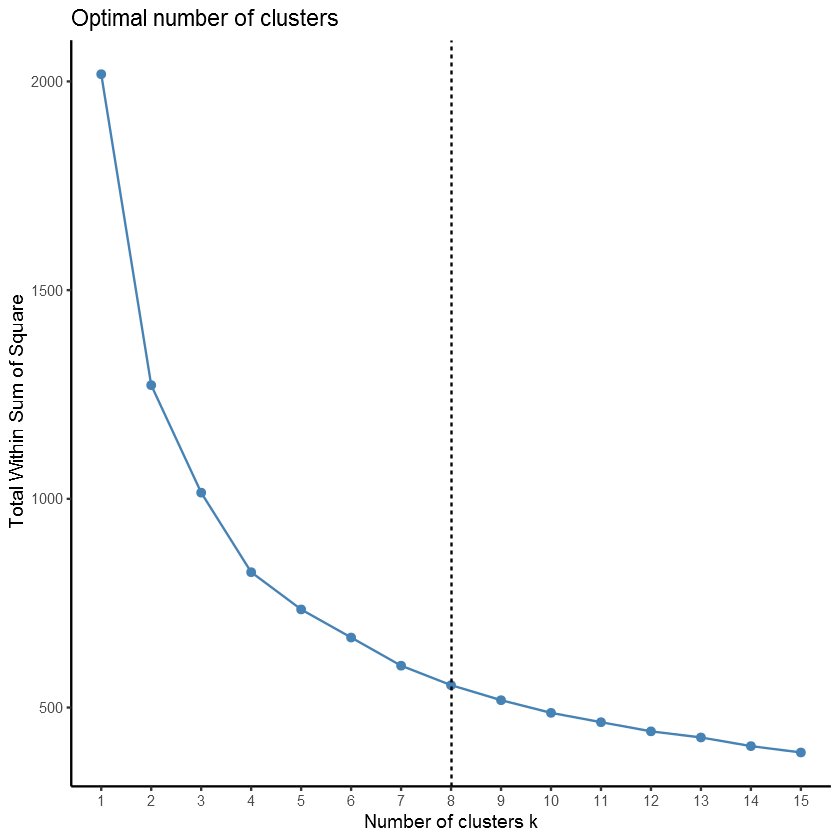

In [416]:

factoextra::fviz_nbclust(promet.whole.Z.mean.v, kmeans, method = "wss",k.max = 15)+ theme_classic()+ geom_vline(xintercept = 8, linetype = 2)

In [158]:
load('./out/20210428_aging/promet/whole/promet_outdata.Rdata')

In [159]:
#mfuzz.promet.whole = mfuzz(promet.whole.Z.mean.eset, c = 8,m = 1.5)
pdf('./out/20230217_aging/Figure3_trajactory_analysis/Figure3_mfuzz_plot_8A_promet.pdf',width = 8,height = 4)
mfuzz.plot(promet.whole.Z.mean.eset,mfuzz.promet.whole,mfrow=c(2,4),time.labels = c("Juvenile", "Young_adult","Middle_aged",
                                   "Elderly"),new.window = F)
dev.off()
mfuzz.promet.whole$size

png 
  2

[1] 565 793 783 822 842 434 606 486

In [423]:
#save(file = paste0('./out/20210428_aging/promet/whole/promet_outdata.Rdata'),
#     list =c('pro.whole','promet.tissues','promet.tissues.info','promet.tissues.Z','promet.whole.Z',
#             'promet.whole.Z.info',  'pro.whole.info','mfuzz.promet.whole'))  
#writetxt(mfuzz.promet.whole$cluster,paste0('./out/20210428_aging/promet/whole/whole_Mfuzz_clusters_promet.txt'),row.names = T)

In [56]:
#save(file = paste0('./out/20210428_aging/promet/tissues/promet_tissues_outdata.Rdata'),
#     list =c('pro.whole','promet.tissues','promet.tissues.info','promet.tissues.Z','promet.whole.Z',
#             'promet.whole.Z.info',  'pro.whole.info','mfuzz.promet.whole',
#            'mfuzz.promet.tissues','promet.tissues.mstd.eset'))  
#writetxt(mfuzz.promet.whole$cluster,paste0('./out/20210428_aging/promet/whole/whole_Mfuzz_clusters_promet.txt'),row.names = T)

## Figure 3B Go enrichment

In [575]:
outids = c()
tpath = paste0('./out/20210428_aging/promet/whole/metascape/metascape_result_curated.xlsx')
    my_data <- read_excel(tpath, sheet = "Enrichment")
    idx = regexpr('Summary',my_data$GroupID) >0
    outids = c(outids,my_data$Term[idx])
outids

tpath = paste0('./out/20210428_aging/promet/whole/metascape/Enrichment_GO/','GO_membership.csv')
thisgo = file2frame(tpath,sep = ',')
thisgo= thisgo[!duplicated(thisgo$GO),]
xid = is.element(thisgo$GO,outids)
thisgo = thisgo[xid,]

#rownames(thisgo) = paste0(thisgo$GO,':',thisgo$Description)
rownames(thisgo) = capitalize(paste0(thisgo$Description))
thisgo.matrix = as.matrix(thisgo[,substr(colnames(thisgo),1,6)== 'X_LogP'])
writetxt(thisgo.matrix,'./out/20230217_aging/Figure3_trajactory_analysis/Table S1_GOenrichment_metascape_promet_clusters.txt',row.names = T)

thisgo.matrix[thisgo.matrix > -3] = 0
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))
colnames(thisgo.matrix) = gsub('Cluster','C',colnames(thisgo.matrix))

pheatmap::pheatmap(thisgo.matrix,cluster_rows = T,cluster_cols = T,fontsize_row = 9,fontsize_col = 10,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = T,
                  color=colorRampPalette(c('#3C5488FF','gray95','gray95'))(7),breaks = c(-32,-24,-16,-8,0),
                  file ="./out/20230217_aging/Figure3_trajactory_analysis/Figure3B_GOenrichment_metascape_prometA.pdf",
                 height = 3.5,width = 5.5
                  )
graphics.off()

[1] "R-HSA-2262752" "GO:0006412"    "GO:0045055"    "R-HSA-199991" 
 [5] "GO:0006163"    "GO:0072594"    "GO:0006091"    "R-HSA-72203"  
 [9] "WP3888"        "GO:0022411"    "GO:0007005"    "GO:0006520"   
[13] "GO:0010256"    "GO:0097435"    "R-HSA-1280215" "GO:0051640"   
[17] "GO:0060627"    "GO:1903827"    "GO:0006914"    "ko04144"

## mfuzz for each tissue

### get data

In [347]:
# construct data
tissue_trajectory = data.frame()
tissue_names = names(promet.tissues)
for(k in 1:8){
    tmpGeneList = names(mfuzz.promet.whole$cluster)[mfuzz.promet.whole$cluster == k]
    for(i in 1:length(promet.tissues)){
        
        M1 = promet.tissues[[i]]
        metadata.tissue = promet.tissues.info[[i]]
        idgene1 = intersect(tmpGeneList,rownames(M1))
        cc = repmat(as.matrix(rowMedians(M1[,metadata.tissue$stage == '1'],na.rm = T)),1,ncol(M1))
        tsd = repmat(as.matrix(apply(M1,1,sd,na.rm = T)),1,ncol(M1))
        
        M1.Z = (M1 - cc)/tsd
        M1.Z.v = M1.Z[idgene1,]
        M1.Z.v.mean = t(aggregate(t(M1.Z.v), by=list(metadata.tissue$stage), FUN=median, na.rm = T))
        M1.Z.v.mean = M1.Z.v.mean[-1,]
        mean_x = colMeans(M1.Z.v.mean,na.rm  =T)
        mean_x = mean_x - mean_x[1]
        
        tmpdata2 = data.frame(expr = mean_x,stringsAsFactors = F,
                              stage = c(1,2,3,4),
                              group = factor(c('Juvenile','Young','Middle_aged','Elderly'),
                                     level = c('Juvenile','Young','Middle_aged','Elderly')),
                              cluster = rep(k,4),
                              tissue = rep(tissue_names[i],4)
                     )
        if (nrow(tissue_trajectory) <1){
            tissue_trajectory = tmpdata2
        }else{
            tissue_trajectory = rbind(tissue_trajectory,tmpdata2)
        }
    }

}


In [535]:
tissue_trajectory$tissue_system = tissue.systems[tissue_trajectory$tissue]
tissue_trajectory$tissue_system_color = tissue.color[tissue_trajectory$tissue_system]

In [518]:
# to matrix
tissue_trajectory_matrix = matrix(0,nrow(tissue_trajectory)/length(tissue_names),length(tissue_names))
for(i in 1:length(tissue_names)){
    tmptr = tissue_trajectory[tissue_trajectory$tissue == tissue_names[i],]
    tissue_trajectory_matrix[,i] = tmptr$expr
}
rownames(tissue_trajectory_matrix) = paste(tmptr$group,tmptr$cluster,sep = '_C')
colnames(tissue_trajectory_matrix) = tissue_names
#colnames(tissue_trajectory_matrix)[colnames(tissue_trajectory_matrix) == 'Arteria_cruralis'] = 'Femoral_artery'


### Figure 3C tissue trajactory

In [582]:
tissue_tr_plot = list()
for (i in 1:8){
    idx = tissue_trajectory$cluster == i
    tissue_tr_plot [[i]] = ggplot(tissue_trajectory[idx,],aes(x= group,y = expr,group  =tissue)) +
        #geom_line()+
        geom_line(aes(color = tissue_system),alpha = 0.3 ,position = position_dodge(0.2),size = 2)+ scale_color_aaas()+ #scale_color_npg()+
        #geom_boxplot(width = 0.5,lwd = 0.6,outlier.color = NA,alpha = 0.2,)+scale_color_npg()+
        lghplot.addtheme(hjust = 1,size = 14)+ ggtitle(paste0('Cluster ',i))+
         theme(axis.line = element_line(size = 1.2))+ xlab('')+ ylab('')+
        #geom_point(aes(fill = group,group = gene),alpha = 0.6,size = 1,position = position_dodge(0.2))+
        scale_y_continuous(labels = scales::comma_format(accuracy =0.1))
    
}


In [583]:
pdf(file = "./out/20230217_aging/Figure3_trajactory_analysis/Figure3c_trajectory_for_each_tissue_aaas.pdf",height = 9,width = 8)
grid.arrange(arrangeGrob(grobs = tissue_tr_plot,ncol = 3,heights = c(4,4,4),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=18)),
                         #bottom = 'pro expression(log2 FPKM)',
                        left = textGrob('Z values', gp=gpar(fontface="bold",  fontsize=18),rot=90)))
dev.off()

png 
  2

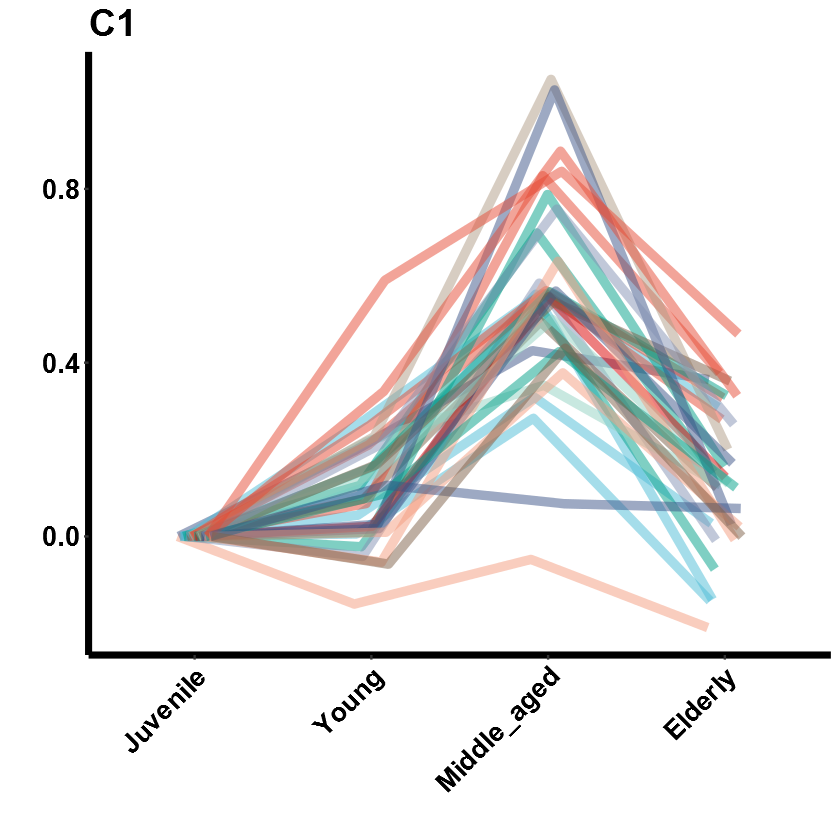

In [552]:
plot(tissue_tr_plot[[1]])

### Figure 3D heatmap clustering

In [708]:
#heatmap cluster '#E64B35FF''#4DBBD5FF'
idx = substr(rownames(tissue_trajectory_matrix),1,3) != 'Juv'
dent = pheatmap::pheatmap(tissue_trajectory_matrix[idx,],scale = 'row',height = 5,width = 6,angle_col = 45,             
                          fontsize_row = 8,fontsize_col = 8,treeheight_row = 20,treeheight_col = 20,
                          #color=colorRampPalette(c('#3B4992','gray95','red'))(30),
                          file ="./out/20230217_aging/Figure3_trajactory_analysis/Figure3D_heatmap_based_trajectoryV1.pdf",
                          color=colorRampPalette(c('#3C5488FF','gray95','#E64B35FF'))(30))


### Figure 3E dendgrogam

In [756]:
dendcol = as.dendrogram(dent$tree_col)

labelColors = c('#3C5488FF','#E64B35FF')

clusMember = cutree(dent$tree_col,2)

# function to get color labels
colLab <- function(n) {
  if (is.leaf(n)) {
    a <- attributes(n)
    labCol <- labelColors[clusMember[which(names(clusMember) == a$label)]]
    attr(n, "nodePar") <- c(a$nodePar, lab.col = labCol)
  }
  n
}
clusDendro = dendrapply(dendcol, colLab)

pdf('./out/20230217_aging/Figure3_trajactory_analysis/Figure3E_dendrogamV1.pdf',width = 7,height = 5)
plot(clusDendro, main = "Molecular trajactory dendgrogram")
dev.off()
#dev.off()



dendcolsplit = cut(dendcol,12)
class1 = unlist(cut(dendcol,12)$lower[[1]])
class2 = unlist(cut(dendcol,12)$lower[[2]])
tissueType = data.frame(tissue = c(tissue_names[class1],tissue_names[class2]),stringsAsFactors = F,
                         type = c(rep('Type II',length(class1)),rep('Type I',length(class2))))
rownames(tissueType) = tissueType$tissue
tissueType$class = tissueType$type
tissueClass  = tissueType

png 
  2

### Figure 3F trajactory pca

In [713]:
# pca
tissue_pca = prcomp(t(tissue_trajectory_matrix),cor=F)
perc_tissue_pca = 100*summary(tissue_pca)$importance

In [717]:
pdf('./out/20230217_aging/Figure3_trajactory_analysis/Figure3F_PCA.pdf',width = 7,height = 7)
TissueType = tissueType[tissue_names,]$type
ggplot(,aes(tissue_pca$x[,1],tissue_pca$x[,2],color = TissueType)) + geom_point(size =5,alpha = 0.6) + 
   theme_classic() +lghplot.addtheme(legend.position = 'top')+  #stat_ellipse(lwd=1,level = 0.95) +
   geom_text_repel(aes(label = tissue_names),size = 5,box.padding = 0.5,face = 'bold')+
   xlab(paste("PC1(",as.character(round(perc_tissue_pca[2,1],1)),'%)',sep = '')) + 
   ylab(paste("PC2(",as.character(round(perc_tissue_pca[2,2],1)),'%)',sep = '')) + scale_color_manual(values = c('#E64B35FF','#3C5488FF'))+
   theme(legend.text = element_text(size=12,face = 'bold'))+
   labs(title = "Molecular trajectory PCA")
dev.off()

png 
  2

### trajectory color by tissue type

In [890]:
tissue_trajectory$tissueClass = tissueClass[tissue_trajectory$tissue,]$class

In [896]:
tissue_tr_plot_bytype = list()
for (i in 1:8){
    idx = tissue_trajectory$cluster == i
    tmpxx = ggplot(tissue_trajectory[idx,],aes(x= group,y = expr,group  =tissue)) +
        #geom_line()+
        geom_line(aes(color = tissueClass),alpha = 0.3 ,position = position_dodge(0.2),size = 2)+ scale_color_manual(values = c('#E64B35FF','#3C5488FF'))+ #  sscale_color_aaas()+ #scale_color_npg()+
        #geom_boxplot(width = 0.5,lwd = 0.6,outlier.color = NA,alpha = 0.2,)+scale_color_npg()+
        lghplot.addtheme(hjust = 1,size = 14)+ ggtitle(paste0('Cluster ',i))+
         theme(axis.line = element_line(size = 1.2))+ xlab('')+ ylab('')+
        #geom_point(aes(fill = group,group = gene),alpha = 0.6,size = 1,position = position_dodge(0.2))+
        scale_y_continuous(labels = scales::comma_format(accuracy =0.1))
    tissue_tr_plot_bytype[[i]] = tmpxx
    
}

In [897]:
pdf(file = "./out/20230217_aging/Figure3_trajactory_analysis/Figure3c_trajectory_for_each_tissue_aaas_color_by_tissueClass.pdf",height = 9,width = 8)
grid.arrange(arrangeGrob(grobs = tissue_tr_plot_bytype,ncol = 3,heights = c(4,4,4),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=18)),
                         #bottom = 'pro expression(log2 FPKM)',
                        left = textGrob('Z values', gp=gpar(fontface="bold",  fontsize=18),rot=90)))
dev.off()

png 
  2

In [898]:
pdf(file = "./out/20230217_aging/Figure3_trajactory_analysis/Figure3c_trajectory_for_each_tissue_aaas_color_by_tissueClass_4col.pdf",height = 8,width = 13)
grid.arrange(arrangeGrob(grobs = tissue_tr_plot_bytype,ncol = 4,heights = c(4,4),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=18)),
                         #bottom = 'pro expression(log2 FPKM)',
                        left = textGrob('Z values', gp=gpar(fontface="bold",  fontsize=18),rot=90)))
dev.off()

png 
  2

In [451]:
#write to metascape
clusterGenes = data.frame(cluster = paste0('C',1:8),stringsAsFactors = F,
                         genes = rep('x',8))
for(i in 1:8){
    tgene = names(mfuzz.promet.whole$cluster)[mfuzz.promet.whole$cluster == i]
    tgene = tgene[substr(tgene,1,4)!= 'met_']
    clusterGenes$genes[i] = paste0(tgene,collapse = ',') 
}
writetxt(clusterGenes,'./out/20210428_aging/promet/whole/metascape/input_8cluster_genes.txt',row.names = F,col.names = F)

## cluster by MAA

In [736]:
promet.norm.eset.stand.matrix = as.matrix(promet.whole.Z.mean.eset)
variability = rep(0,8) 
for(j in 1:8){
    tgene = names(mfuzz.promet.whole$cluster)[mfuzz.promet.whole$cluster == j]
    tgene = intersect(tgene,rownames(promet.norm.eset.stand.matrix))
    bx = t(t(promet.norm.eset.stand.matrix[tgene,]) - mfuzz.promet.whole$centers[j,])
    variability[j] = mean(sqrt(rowSums(bx^2)/(ncol(bx)-1)))
}
tmpdata = data.frame(amplitude = as.vector(mfuzz.promet.whole$centers[,4]-mfuzz.promet.whole$centers[,1]),
                     stringsAsFactors = F,
                     variability = variability,
                     class = paste0('Cluster ',1:8))
pdf(file ='./out/20230217_aging/Figure3_trajactory_analysis/FigureX_cluster_amplitude_variability_8_promet.pdf',width = 7,height = 5)
ggplot(tmpdata,aes(variability,amplitude)) + geom_point(size = 4) + lghplot.addtheme(size = 18)+
  geom_text_repel(aes(label = class),size = 7)+theme(axis.line = element_line(size = 1.0))
dev.off()


png 
  2

In [737]:
tissues = names(promet.tissues.Z)
clusterdist = matrix(0,length(tissues),8)
clusteramplitude = matrix(0,length(tissues),8)
clusteramplitude_xx = matrix(0,length(tissues),8)
for(i in 1:length(tissues)){
    mstd =   promet.tissues.Z[[i]] 
    for(j in 1:8){
    tgene = names(mfuzz.promet.whole$cluster)[mfuzz.promet.whole$cluster == j]
    tgene = intersect(tgene,rownames(mstd))
    bx = t(t(mstd[tgene,]) - mfuzz.promet.whole$centers[j,])
    clusterdist[i,j] = mean(sqrt(rowSums(bx^2)/(ncol(bx)-1)),na.rm = T)
    if(length(tgene) < 2){
      clusteramplitude[i,j] = NA
      next;
    }
    tamp = colMeans(mstd[tgene,],na.rm = T)
    clusteramplitude[i,j] = abs(tamp[4]-tamp[1])
    clusteramplitude_xx[i,j] = tamp[4]-tamp[1]
  }
}
rownames(clusteramplitude) = tissues
rownames(clusteramplitude_xx) = tissues
rownames(clusterdist) = tissues

In [814]:
px = list()
for(j in 1:8){
  tmpdata = data.frame(amplitude = clusteramplitude_xx[,j],
                       stringsAsFactors = F,
                       variability = clusterdist[,j],
                       class = tissues,
                      tissue.systems = tissue.systems)
    px[[j]] = ggplot(tmpdata,aes(variability,amplitude,color = tissue.systems)) + geom_point(size = 6) + lghplot.addtheme(size = 14)+
    scale_color_aaas()+scale_fill_aaas()+
    geom_text_repel(aes(label = class),size = 3,box.padding = 0.5)+
    theme(axis.line = element_line(size = 1.5))+ ggtitle(paste0('Cluster ',j))+ xlab('') + ylab('')
}

In [815]:
pdf(file = "./out/20230217_aging/Figure3_trajactory_analysis/FigureXS_cluster8_tissues_amplitude_variability_allV2.pdf",height = 9,width = 16)
grid.arrange(arrangeGrob(grobs = px,ncol = 4,margin = c(1,1,1,1),
                         bottom=textGrob('Molecular alteration variability', gp=gpar(fontface="bold",  fontsize=24)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Molecular alteration amplitude(MAA)', gp=gpar(fontface="bold",  fontsize=24),rot=90)))
dev.off()

png 
  2

In [740]:
tmpaa = clusteramplitude_xx
colnames(tmpaa) = paste0("C",1:8)
dent.MAA = pheatmap::pheatmap(tmpaa,scale = 'none',height = 4,width = 3.5,
                          fontsize_row = 7,fontsize_col = 7,treeheight_row = 20,treeheight_col = 20,
                          color=colorRampPalette(c('#3B4992','gray95','red'))(30),
             filename = './out/20230217_aging/Figure3_trajactory_analysis/FigureX_promet_heatmap_tissue_aging_byMAA.pdf')


In [746]:
dendrow = as.dendrogram(dent.MAA$tree_row)

labelColors = c('#3C5488FF','#E64B35FF')

clusMember = cutree(dent.MAA$tree_row,2)

# function to get color labels
colLab <- function(n) {
  if (is.leaf(n)) {
    a <- attributes(n)
    labCol <- labelColors[clusMember[which(names(clusMember) == a$label)]]
    attr(n, "nodePar") <- c(a$nodePar, lab.col = labCol)
  }
  n
}
clusDendro = dendrapply(dendrow, colLab)

pdf('./out/20230217_aging/Figure3_trajactory_analysis/FigureX_dendrogam_by_MAA.pdf',width = 7,height = 5)
plot(clusDendro, main = "Molecular trajactory dendgrogram by MAA")
dev.off()
#dev.off()

png 
  2

In [757]:
mean_clusteramplitude_xx = rowMeans(clusteramplitude_xx)
names(mean_clusteramplitude_xx) = rownames(clusteramplitude_xx)
tissues_pro = rownames(clusteramplitude_xx)
dendrow = as.dendrogram(dent.MAA$tree_row)
dendrowsplit = cut(dendrow,2.5)
class1 = unlist(cut(dendrow,2.5)$lower[[1]])
class2 = unlist(cut(dendrow,2.5)$lower[[2]])
tissueClass.MAA = data.frame(tissue = c(tissues_pro[class1],tissues_pro[class2]),stringsAsFactors = F,
                         class = c(rep('Type II',length(class1)),rep('Type I',length(class2))))
rownames(tissueClass.MAA)  = tissueClass.MAA$tissue
tissueClass.MAA$mean_aging_amplitude=mean_clusteramplitude_xx[rownames(tissueClass.MAA)]

In [758]:
tissueClass$class.MAA = tissueClass.MAA[rownames(tissueClass),]$class
tissueClass$mean_aging_amplitude = tissueClass.MAA[rownames(tissueClass),]$mean_aging_amplitude

In [759]:
tissueClass$type = rep('Undefine',nrow(tissueClass))
tissueClass$type[tissueClass$class == 'Type I' & tissueClass$class.MAA == 'Type I'] = 'Type I'
tissueClass$type[tissueClass$class == 'Type II' & tissueClass$class.MAA == 'Type II'] = 'Type II'
tissueClass

,tissue,type,class,class.MAA,mean_aging_amplitude
,<chr>,<chr>,<chr>,<chr>,<dbl>
Pancreas,Pancreas,Type II,Type II,Type II,-0.075748775
Supramarginal_gyrus,Supramarginal_gyrus,Type II,Type II,Type II,0.231195111
Frontal_pole,Frontal_pole,Type II,Type II,Type II,0.186849533
Liver,Liver,Type II,Type II,Type II,0.210951149
Hippocampus,Hippocampus,Type II,Type II,Type II,0.044697652
Skin_of_back,Skin_of_back,Type II,Type II,Type II,0.153227025
Cecum,Cecum,Type II,Type II,Type II,0.117593492
Lung,Lung,Type II,Type II,Type II,0.062388571
Superior_temporal_gyrus,Superior_temporal_gyrus,Type II,Type II,Type II,0.151674043


In [820]:
#
require(VennDiagram)
tmpnames = rownames(tissueClass)
Trajactory_Type_I = tmpnames[tissueClass$class == 'Type I']
Trajactory_Type_II = tmpnames[tissueClass$class == 'Type II']
MAA_Type_I = tmpnames[tissueClass$class.MAA == 'Type I']
MAA_Type_II = tmpnames[tissueClass$class.MAA == 'Type II']
venn.diagram(list(Trajactory_Type_I=Trajactory_Type_I,Trajactory_Type_II = Trajactory_Type_II,
                  MAA_Type_I = MAA_Type_I,MAA_Type_II=MAA_Type_II), 
             #fill=c("red","blue",),
             fill = c("cornflowerblue", "green", "yellow", "darkorchid1"),
             alpha=c(0.5,0.5,0.5,0.5), cex=2, cat.fontface=3, cat.cex = 1.3,margin = 0.1,
             filename="./out/20230217_aging/Figure3_trajactory_analysis/Venn_trajactory_and_MAA.tiff")

[1] 1

## Figure S3 mRNA for compare

[1] 9375  517

0 genes excluded.


png 
  2

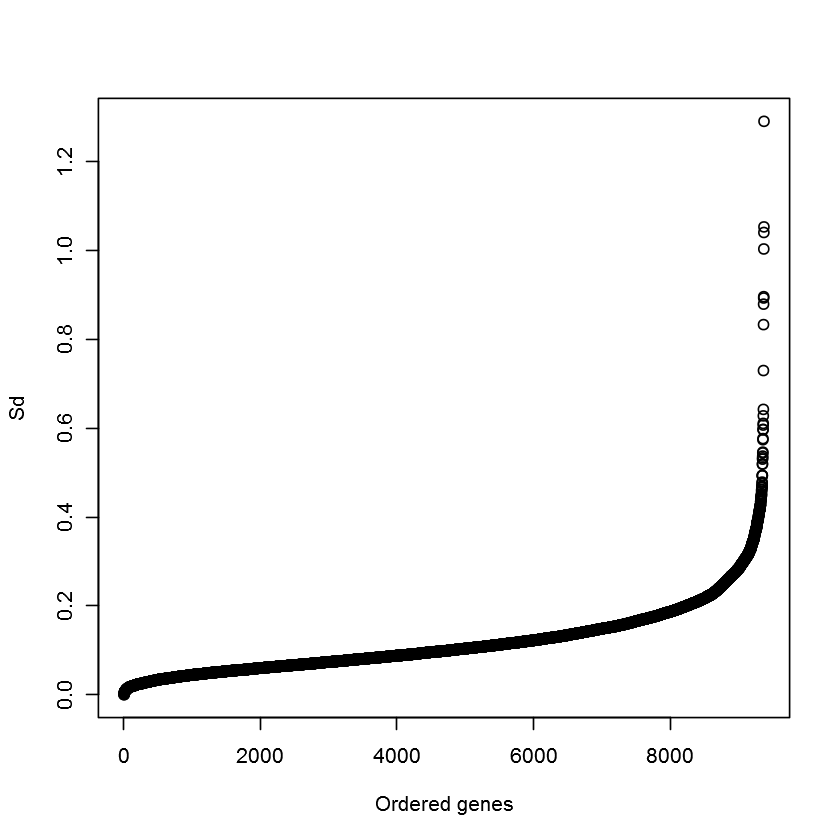

In [585]:
tmp = mrna.whole
tmp = tmp[intersect(rownames(tmp),rownames(promet.whole.Z)),]
dim(tmp)
mrna.norm.mean = t(aggregate(t(tmp), by=list(mrna.whole.info$stage), FUN=mean, na.rm = T))
mrna.norm.eset = new("ExpressionSet",exprs = mrna.norm.mean)
mrna.norm.eset = filter.std(mrna.norm.eset,min.std=0)
mrna.norm.eset.stand  =  standardise(mrna.norm.eset)

mfuzz.mrna.whole = mfuzz(mrna.norm.eset.stand, c = 8,m = 1.5)
pdf('./out/20230217_aging/Figure3_trajactory_analysis/Supplymentary_FigureS3A_mfuzz_plot_8A_mrna_whole_V1.pdf',width = 8,height = 4)
mfuzz.plot(mrna.norm.eset.stand,mfuzz.mrna.whole,mfrow=c(2,4),time.labels = intersect(c("Juvenile", "Young_adult","Middle_aged",
                                   "Elderly"),unique(mrna.whole.info$type)),new.window = F)
dev.off()

In [613]:
#save for reproduction
save(file = './out/20230217_aging/Figure3_trajactory_analysis/mRNA_mfuzz_data_for_replication.Rdata',list = c('mfuzz.mrna.whole','mrna.norm.eset.stand','mrna.whole.info','mrna.whole'))

In [589]:
# construct data
tissue_trajectory.mrna = data.frame()
#tissue_names.mrna = names(mrna.tissues)
for(k in 1:8){
    tmpGeneList = names(mfuzz.mrna.whole$cluster)[mfuzz.mrna.whole$cluster == k]
    for(i in 1:length(tissue_names)){
        
        tid = tissue_names[i]
        M1 = mrna.tissues[[tid]]
        metadata.tissue = mrna.tissues.info[[tid]]
        idgene1 = intersect(tmpGeneList,rownames(M1))
        cc = repmat(as.matrix(rowMedians(M1[,metadata.tissue$stage == '1'],na.rm = T)),1,ncol(M1))
        tsd = repmat(as.matrix(apply(M1,1,sd,na.rm = T)),1,ncol(M1))
        
        M1.Z = (M1 - cc)/tsd
        M1.Z.v = M1.Z[idgene1,]
        M1.Z.v.mean = t(aggregate(t(M1.Z.v), by=list(metadata.tissue$stage), FUN=median, na.rm = T))
        M1.Z.v.mean = M1.Z.v.mean[-1,]
        mean_x = colMeans(M1.Z.v.mean,na.rm  =T)
        mean_x = mean_x - mean_x[1]
        
        tmpdata2 = data.frame(expr = mean_x,stringsAsFactors = F,
                              stage = c(1,2,3,4),
                              group = factor(c('Juvenile','Young','Middle_aged','Elderly'),
                                     level = c('Juvenile','Young','Middle_aged','Elderly')),
                              cluster = rep(k,4),
                              tissue = rep(tissue_names[i],4)
                     )
        if (nrow(tissue_trajectory.mrna) <1){
            tissue_trajectory.mrna = tmpdata2
        }else{
            tissue_trajectory.mrna = rbind(tissue_trajectory.mrna,tmpdata2)
        }
    }

}

In [590]:
tissue_trajectory.mrna$tissue_system = tissue.systems[tissue_trajectory.mrna$tissue]
tissue_trajectory.mrna$tissue_system_color = tissue.color[tissue_trajectory.mrna$tissue_system]

In [591]:
### Figure S3 tissue trajactory mRNA
# to matrix
tissue_trajectory_matrix.mrna = matrix(0,nrow(tissue_trajectory.mrna)/length(tissue_names),length(tissue_names))
for(i in 1:length(tissue_names)){
    tmptr = tissue_trajectory.mrna[tissue_trajectory.mrna$tissue == tissue_names[i],]
    tissue_trajectory_matrix.mrna[,i] = tmptr$expr
}
rownames(tissue_trajectory_matrix.mrna) = paste(tmptr$group,tmptr$cluster,sep = '_C')
colnames(tissue_trajectory_matrix.mrna) = tissue_names
#colnames(tissue_trajectory_matrix)[colnames(tissue_trajectory_matrix) == 'Arteria_cruralis'] = 'Femoral_artery'


In [592]:
tissue_tr_plot.mrna = list()
for (i in 1:8){
    idx = tissue_trajectory.mrna$cluster == i
    tissue_tr_plot.mrna [[i]] = ggplot(tissue_trajectory.mrna[idx,],aes(x= group,y = expr,group  =tissue)) +
        #geom_line()+
        geom_line(aes(color = tissue_system),alpha = 0.5 ,position = position_dodge(0.2),size = 2)+ scale_color_npg()+
        #geom_boxplot(width = 0.5,lwd = 0.6,outlier.color = NA,alpha = 0.2,)+scale_color_npg()+
        lghplot.addtheme(hjust = 1,size = 14)+ ggtitle(paste0('Cluster ',i))+
         theme(axis.line = element_line(size = 1.2))+ xlab('')+ ylab('')+
        #geom_point(aes(fill = group,group = gene),alpha = 0.6,size = 1,position = position_dodge(0.2))+
        scale_y_continuous(labels = scales::comma_format(accuracy =0.1))
    
}

In [593]:
pdf(file = "./out/20230217_aging/Figure3_trajactory_analysis/FigureS3_trajectory_for_each_tissue_mRNA.pdf",height = 9,width = 8)
grid.arrange(arrangeGrob(grobs = tissue_tr_plot.mrna,ncol = 3,heights = c(4,4,4),
                         bottom=textGrob('Tissues', gp=gpar(fontface="bold",  fontsize=18)),
                         #bottom = 'pro expression(log2 FPKM)',
                        left = textGrob('Z values', gp=gpar(fontface="bold",  fontsize=18),rot=90)))
dev.off()

png 
  2

In [657]:
#heatmap cluster '#E64B35FF''#4DBBD5FF'
idx = substr(rownames(tissue_trajectory_matrix.mrna),1,3) != 'Juv'
dent.mrna = pheatmap::pheatmap(tissue_trajectory_matrix.mrna[idx,],scale = 'row',height = 5,width = 6,angle_col = 45,clustering_method ='ward.D2',   
                          fontsize_row = 8,fontsize_col = 8,treeheight_row = 20,treeheight_col = 20,
                          #color=colorRampPalette(c('#3B4992','gray95','red'))(30),
                          file ="./out/20230217_aging/Figure3_trajactory_analysis/FigureS3_heatmap_based_trajectory_mrna.ward.D2.pdf",
                          color=colorRampPalette(c('#4DBBD5FF','gray95','#E64B35FF'))(30))

In [597]:
dendcol = as.dendrogram(dent.mrna$tree_col)

labelColors = c('#3C5488FF','#E64B35FF')

clusMember = cutree(dent.mrna$tree_col,2)

# function to get color labels
colLab <- function(n) {
  if (is.leaf(n)) {
    a <- attributes(n)
    labCol <- labelColors[clusMember[which(names(clusMember) == a$label)]]
    attr(n, "nodePar") <- c(a$nodePar, lab.col = labCol)
  }
  n
}
clusDendro = dendrapply(dendcol, colLab)

pdf('./out/20230217_aging/Figure3_trajactory_analysis/FigureS3_dendrogam_mrna.pdf',width = 7,height = 5)
plot(clusDendro, main = "Molecular trajactory dendgrogram")
dev.off()
#dev.off()



dendcolsplit = cut(dendcol,12)
class1 = unlist(cut(dendcol,12)$lower[[1]])
class2 = unlist(cut(dendcol,12)$lower[[2]])
tissueType.mrna = data.frame(tissue = c(tissue_names[class1],tissue_names[class2]),stringsAsFactors = F,
                         type = c(rep('Type II',length(class1)),rep('Type I',length(class2))))
rownames(tissueType.mrna) = tissueType.mrna$tissue

png 
  2

In [599]:
# pca
tissue_pca.mrna = prcomp(t(tissue_trajectory_matrix.mrna),cor=F)
perc_tissue_pca.mrna = 100*summary(tissue_pca.mrna)$importance

pdf('./out/20230217_aging/Figure3_trajactory_analysis/FigureS3_PCA_mrna.pdf',width = 7,height = 7)
TissueType.mrna = tissueType.mrna[tissue_names,]$type
ggplot(,aes(tissue_pca.mrna$x[,1],tissue_pca.mrna$x[,2],color = TissueType.mrna)) + geom_point(size =5,alpha = 0.6) + 
   theme_classic() +lghplot.addtheme(legend.position = 'top')+  #stat_ellipse(lwd=1,level = 0.95) +
   geom_text_repel(aes(label = tissue_names),size = 5,box.padding = 0.5,face = 'bold')+
   xlab(paste("PC1(",as.character(round(perc_tissue_pca[2,1],1)),'%)',sep = '')) + 
   ylab(paste("PC2(",as.character(round(perc_tissue_pca[2,2],1)),'%)',sep = '')) + scale_color_manual(values = c('#E64B35FF','#3C5488FF'))+
   theme(legend.text = element_text(size=12,face = 'bold'))+
   labs(title = "Molecular trajectory PCA")
dev.off()


png 
  2

## combine all molecular

### get data

In [618]:
tissues = names(pro.tissues)
mrnapromet.tissues = list()
mrnapromet.tissues.info = list()
mrnapromet.tissues.Z = list()
mfuzz.mrnapromet.tissues = list()
mrnapromet.mstd.eset = list()
for(i in 1:length(tissues)){
#for(i in 1:1){
    tt = tissues[i]
    thispro = pro.tissues[[tt]]
    thispro = delete_dup_genes_forprotein(thispro,pro.tissues.header[[tt]])
    thispro.header = pro.tissues.header[[tt]]
    thispro = thispro[rowSums(is.na(thispro)) < 1/3*ncol(thispro), ]
    
    thismet = met.tissues[[tt]]
    rownames(thismet) = paste0('met_',rownames(thismet))
    thismrnapromet = rbind2(thispro,thismet)
    
    thismrna = mrna.tissues[[tt]]
    xid = setdiff(colnames(thismrna),colnames(thismrnapromet))
    if(length(xid) > 0){
        thismrna = thismrna[,!is.element(colnames(thismrna),xid)]
    }
    rownames(thismrna) = paste0('mrna_',rownames(thismrna))
    
    thismrnapromet = rbind2(thismrnapromet,thismrna)
     
    thisinfo = pro.tissues.info[[tt]]
    thisinfo = thisinfo[colnames(thismrnapromet),]
    
    
    
    thismrnapromet.median = t(aggregate(t(thismrnapromet), by=list(thisinfo$stage), FUN=median, na.rm = T))
    mstd = standardise_matrix(thismrnapromet.median)
    mrnapromet.tissues.Z[[i]] = mstd
    mrnapromet.tissues[[i]] = thismrnapromet
    mrnapromet.tissues.info[[i]] = thisinfo
    mstd.v = mstd[rowSums(is.na(mstd))  == 0,]
    mstd.eset = new("ExpressionSet",exprs = mstd.v)
    mrnapromet.mstd.eset[[i]] = mstd.eset
    mfuzz.mrnapromet.tissues[[i]] = mfuzz(mstd.eset, c = 8,m = 1.5)

}
names(mfuzz.mrnapromet.tissues) = tissues
names(mrnapromet.tissues) = tissues
names(mrnapromet.tissues.Z) = tissues
names(mrnapromet.tissues.info) = tissues
names(mrnapromet.mstd.eset) = tissues

### mfuzz

In [619]:
mrnapromet.tissues.Z.t = list()
for(i in 1:length(mrnapromet.tissues.Z)){
    tmp = as.data.frame(t(mrnapromet.tissues.Z[[i]]))
    mrnapromet.tissues.Z.t[[i]] = tmp
}
names(mrnapromet.tissues.Z.t) = names(mrnapromet.tissues.Z)

In [620]:
mrnapromet.whole.Z = t(as.matrix(as.data.frame(rbindlist(mrnapromet.tissues.Z.t,fill = T))))
colnames(mrnapromet.whole.Z) = paste0(rep(names(mrnapromet.tissues.Z),each = 4),'_',rep(1:4,times = 30))
mrnapromet.whole.Z.info = data.frame(tissue = rep(names(mrnapromet.tissues.Z),each = 4),stringsAsFactors = F,
                                stage = rep(1:4,times = 30))
rownames(mrnapromet.whole.Z.info) = colnames(mrnapromet.whole.Z)

In [627]:
mrnapromet.whole.Z.v = mrnapromet.whole.Z[rowSums(is.na(mrnapromet.whole.Z)) < 0.5*120,]
mrnapromet.whole.Z.mean = t(aggregate(t(mrnapromet.whole.Z.v), by=list(mrnapromet.whole.Z.info$stage), FUN=mean, na.rm = T))
mrnapromet.whole.Z.mean  =mrnapromet.whole.Z.mean[-1,]
mrnapromet.whole.Z.mean.v = mrnapromet.whole.Z.mean[rowSums(is.na(mrnapromet.whole.Z.mean))  == 0,]
mrnapromet.whole.Z.mean.eset = new("ExpressionSet",exprs = mrnapromet.whole.Z.mean.v)
dim(mrnapromet.whole.Z.mean.v)
sum(substr(rownames(mrnapromet.whole.Z.mean.v),1,4) == 'met_')
sum(substr(rownames(mrnapromet.whole.Z.mean.v),1,5) == 'mrna_')
#mfuzz.mrnapromet.whole = mfuzz(mrnapromet.norm.eset.stand, c = 8,m = 1.5)

[1] 17121     4

[1] 1221

[1] 11790

In [630]:
# mfuzz
mfuzz.mrnapromet.whole = mfuzz(promet.whole.Z.mean.eset, c = 8,m = 1.5)

In [631]:
pdf('./out/20230217_aging/Figure3_trajactory_analysis/Supplymentary_FigureS_mfuzz_plot_8A_mrnapromet_whole_V1.pdf',width = 8,height = 4)
mfuzz.plot(mrnapromet.whole.Z.mean.eset,mfuzz.mrnapromet.whole,mfrow=c(2,4),time.labels = intersect(c("Juvenile", "Young_adult","Middle_aged",
                                   "Elderly"),unique(mrna.whole.info$type)),new.window = F)
dev.off()

png 
  2

# Figure 4_markers_and_HE

## protein markers

In [766]:
yy1$type

[1] "Type II"  "Type I"   "Type II"  "Type II"  "Type II"  "Undefine"
 [7] "Undefine" "Type II"  "Type I"   "Type I"   "Undefine" "Type II" 
[13] "Type I"   "Type II"  "Type II"  "Type I"   "Type I"   "Type II" 
[19] "Type I"   "Type I"   "Type I"   "Type II"  "Type II"  "Type I"  
[25] "Undefine" "Type II"  "Type II"  "Type I"   "Type I"   "Type I"

In [905]:
graphics.off()

In [906]:
# Figure 5A all changed protein
tx = colSums(abs(Aging_pro_sigall_matrix),na.rm = T)
yy1 = tissueClass[names(tx),]
#idx = yy1$type != 'Undefine'
pdf('./out/20230217_aging/Figure4_markers_HE/Figure4A_allchanged_proteinsV2.pdf')
ggplot(,aes(x = yy1$type,y = tx,color = yy1$type,fill = yy1$type)) +#geom_violin()+
     geom_boxplot(outlier.size = -1,alpha = 0.1,size = 0.8)+
     geom_jitter(size = 5,width = 0.3)+ theme_classic() + 
     lghplot.addtheme()+ scale_color_manual(values=c('#EE0000','#3B4992','gray10'))+
     xlab('Tissue Type')+ylab('Number of changed proteins')
dev.off()
wilcox.test(tx~yy1$type,subset= yy1$type != 'Undefine')     
t.test(tx~yy1$type,subset= yy1$type != 'Undefine') 

png 
  2


	Wilcoxon rank sum test

data:  tx by yy1$type
W = 143, p-value = 0.001914
alternative hypothesis: true location shift is not equal to 0



	Welch Two Sample t-test

data:  tx by yy1$type
t = 2.0597, df = 12.441, p-value = 0.06099
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18.87428 721.95120
sample estimates:
 mean in group Type I mean in group Type II 
             611.8462              260.3077 


In [907]:
# Figure 5A all changed protein
tx = colSums(abs(Aging_pro_sigall_matrix),na.rm = T)/colSums(!is.na(Aging_pro_sigall_matrix))
yy1 = tissueClass[names(tx),]
pdf('./out/20230217_aging/Figure4_markers_HE/Figure4B_allchanged_proteins_percentageV2.pdf')
ggplot(,aes(x = yy1$type,y = tx*100,color = yy1$type,fill = yy1$type)) +#geom_violin()+
     geom_boxplot(outlier.size = -1,alpha = 0.1,size = 0.8)+
     geom_jitter(size = 5,width = 0.3)+ theme_classic() + 
     lghplot.addtheme()+ scale_color_manual(values=c('#EE0000','#3B4992','gray10'))+
     xlab('Tissue Type')+ylab('Percentage of changed proteins(%)')
dev.off()
wilcox.test(tx~yy1$type,subset= yy1$type != 'Undefine')
t.test(tx~yy1$type,subset= yy1$type != 'Undefine')


png 
  2


	Wilcoxon rank sum test

data:  tx by yy1$type
W = 136, p-value = 0.007244
alternative hypothesis: true location shift is not equal to 0



	Welch Two Sample t-test

data:  tx by yy1$type
t = 2.009, df = 13.78, p-value = 0.06454
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.003822324  0.114340586
sample estimates:
 mean in group Type I mean in group Type II 
           0.10606541            0.05080628 


## metabolite markers

In [770]:
# Figure 5C all changed protein
tx = colSums(abs(Aging_met_sigall_matrix),na.rm = T)
yy1 = tissueClass[names(tx),]
pdf('./out/20230217_aging/Figure4_markers_HE/Figure4C_allchanged_metabolites.pdf')
ggplot(,aes(x = yy1$type,y = tx,color = yy1$type,fill = yy1$type)) +#geom_violin()+
     geom_boxplot(outlier.size = -1,alpha = 0.1,size = 0.8)+
     geom_jitter(size = 5,width = 0.3)+ theme_classic() + 
     lghplot.addtheme()+scale_color_npg(alpha = 0.6)+#scale_color_manual(values=c('#BB0021', '#3B4992'))+
     xlab('Tissue Type')+ylab('Number of changed metabolites')
dev.off()
wilcox.test(tx~yy1$type,subset= yy1$type != 'Undefine')

png 
  2


	Wilcoxon rank sum test with continuity correction

data:  tx by yy1$type
W = 121, p-value = 0.06482
alternative hypothesis: true location shift is not equal to 0


In [771]:
# Figure 5C all changed protein
tx = colSums(abs(Aging_met_sigall_matrix),na.rm = T)/colSums(!is.na(Aging_met_sigall_matrix),na.rm = T)
yy1 = tissueClass[names(tx),]
pdf('./out/20230217_aging/Figure4_markers_HE/Figure4D_allchanged_metabolites_percentage.pdf')
ggplot(,aes(x = yy1$type,y = tx*100,color = yy1$type,fill = yy1$type)) +#geom_violin()+
     geom_boxplot(outlier.size = -1,alpha = 0.1,size = 0.8)+
     geom_jitter(size = 5,width = 0.3)+ theme_classic() + 
     lghplot.addtheme()+scale_color_npg(alpha = 0.6)+#scale_color_manual(values=c('#BB0021', '#3B4992'))+
     xlab('Tissue Type')+ylab('Percentage of changed metabolites(%)')
dev.off()
wilcox.test(tx~yy1$type,subset= yy1$type != 'Undefine')

png 
  2


	Wilcoxon rank sum test

data:  tx by yy1$type
W = 116, p-value = 0.1129
alternative hypothesis: true location shift is not equal to 0


## P16 immuno markers

In [722]:
p16 = file2frame('./data/p16_20220519v1.txt')
rankTissues = c('Aortic_arch','Spleen','Kidney','ovary','Thymus','Stomach','Thyroid_gland','Muscle','Pancreas','Liver','Lung','Skin_of_back')
p16$Area.Density[p16$Area.Density < 1e-9] = min(p16$Area.Density[p16$Area.Density > 1e-9])
p16$Area.Density.log2 = log2(p16$Area.Density)
pdf('./out/20230217_aging/Figure4_markers_HE/Figure4E_P16_different_tissue.pdf')
ggplot(p16[p16$stage == 'Elderly',],aes(x = factor(tissue,levels = rankTissues),y = Area.Density.log2,color = class)) +
       geom_boxplot(outlier.size = -1,alpha = 0.1,size = 0.7)+
     geom_jitter(size = 4,width = 0.3)+ theme_classic(base_line_size = 1) + 
     lghplot.addtheme(hjust = 1,legend.position = 'right')+scale_color_manual(values=c('#BB0021', '#3B4992'))+
     xlab('Tissues') + ylab('log2 p16 Density')+ ggtitle('P16 Density in different types of Tissue')
dev.off()
t.test(Area.Density~ class, data = p16)
#plot(lghplot.boxplot(p))

png 
  2


	Welch Two Sample t-test

data:  Area.Density by class
t = 3.6559, df = 221.84, p-value = 0.0003201
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.001699175 0.005673408
sample estimates:
 mean in group Type I mean in group Type II 
          0.006389494           0.002703202 


In [158]:
p16 = file2frame('./data/P16_tissues_v20230419.txt')
utissue = unique(p16$Tissue)
utissue

[1] "Aortic_arch"   "Spleen"        "Kidney"        "Ovary"        
 [5] "Thymus"        "Uterus"        "Thyroid_gland" "Stomach"      
 [9] "Pancreas"      "Skin_of_back"  "Lung"          "Liver"        
[13] "Muscle"

In [4]:
utissue

[1] "Aortic_arch"   "Spleen"        "Kidney"        "Ovary"        
 [5] "Thymus"        "Uterus"        "Thyroid_gland" "Pancreas"     
 [9] "Skin_of_back"  "Lung"          "Liver"         "Muscle"

In [5]:
dev.off()


null device 
          1

In [177]:
p16 = file2frame('./data/P16_tissues_v20230419.txt')
utissue = unique(p16$Tissue)
tpvalues = data.frame(tissue = utissue,
                     p_Juvenile_vs_Elderly = rep(1,length(utissue)),
                     p_Young_vs_Elderly = rep(1,length(utissue)))
breaks_A = c(0.01,0.08,0.08,0.08,0.08,0.01,0.01,0.01)
breaks_B = c(3,3,3,3,2,2,0.06,3)
for(i in 1:length(utissue)){
    tmpdata = p16[p16$Tissue == utissue[i],]
    tmpdata$Area.Density.log2 = tmpdata$Area.Density*1e3#log2(tmpdata$Area.Density*1e3)
    tmpdata$class = factor(x = tmpdata$class,levels = c('Juvenile','Young','Elderly'))
    tmpp1 = t.test(Area.Density~class,data = tmpdata,subset = tmpdata$class != 'Young')$p.value
    tmpp2 = t.test(Area.Density~class,data = tmpdata,subset = tmpdata$class != 'Juvenile')$p.value
    tpvalues$p_Juvenile_vs_Elderly[i] = tmpp1
    tpvalues$p_Young_vs_Elderly[i] = tmpp2
    
    df2 = data.frame(tmean = aggregate(tmpdata$Area.Density.log2, by=list(tmpdata$class), FUN=mean, na.rm = T)$x,
                tsd = aggregate(tmpdata$Area.Density.log2, by=list(tmpdata$class), FUN=sd, na.rm = T)$x,
                    class = factor(x= c('Juvenile','Young','Elderly'),levels = c('Juvenile','Young','Elderly'))
                 )
    thepath = paste0('./out/20230217_aging/Figure4_markers_HE/Figure4x_p16_stats', utissue[i],'.pdf')
    pdf(thepath)
    p = ggplot(df2, aes(x = class, y = tmean, fill = class)) + geom_bar(stat = 'identity',color = 'black',position = position_dodge(),alpha = 0.5,size = 1.5)+
      geom_errorbar(aes(ymin = tmean,ymax = tmean+tsd),width = .3,size = 1.5)+lghplot.addthemeA(size = 28,sizex = 26,sizey = 26)+
      scale_fill_manual(values = c('#008B45FF','#3B4992FF','#EE0000FF'))+ 
      theme(axis.line = element_line(size = 1.2))+ xlab('')+ 
    ylab(bquote('Area Density ' ~ italic(x10) ^italic(3)))+
    #ylab('Log10 Area Density x 1e-7')+
    ggtitle(utissue[i])
    if(i <=8){
        p = p+ scale_y_break(c(breaks_A[i],breaks_B[i]), scales = "free",space  = 0.2)
    }
    
    print(p)
    dev.off()
}

In [178]:
tpvalues

tissue,p_Juvenile_vs_Elderly,p_Young_vs_Elderly
<fct>,<dbl>,<dbl>
Aortic_arch,4.546295e-03,4.553667e-03
Spleen,2.928558e-03,2.941005e-03
Kidney,3.607333e-04,3.618602e-04
Ovary,2.399612e-03,2.487708e-03
Thymus,1.122249e-02,1.151782e-02
Uterus,1.052903e-04,1.057245e-04
Thyroid_gland,6.633705e-04,6.751286e-04
Stomach,3.601685e-05,3.616963e-05
Pancreas,2.616949e-02,5.453556e-03


## p21 immuno markers

In [723]:
p21 = file2frame('./data/p21_20220519v1.txt')
p21$Area.Density[p21$Area.Density < 1e-9] = min(p16$Area.Density[p21$Area.Density > 1e-9])
p21$Area.Density.log2 = log2(p21$Area.Density)
pdf('./out/20230217_aging/Figure4_markers_HE/Figure4F_P21_different_tissue.pdf')
ggplot(p21[p21$stage == 'Elderly',],aes(x = factor(tissue,levels = rankTissues),y = Area.Density.log2,color = class)) +
       geom_boxplot(outlier.size = -1,alpha = 0.1,size = 0.7)+
     geom_jitter(size = 4,width = 0.3)+ theme_classic(base_line_size = 1) + 
     lghplot.addtheme(hjust = 1,legend.position = 'right')+scale_color_manual(values=c('#BB0021', '#3B4992'))+
     xlab('Tissues') + ylab('log2 p21 Density')+ ggtitle('P21 Density in different types of Tissue')
dev.off()
#plot(lghplot.boxplot(p))
t.test(Area.Density~ class, data = p21)

png 
  2


	Welch Two Sample t-test

data:  Area.Density by class
t = 2.3488, df = 110.56, p-value = 0.02061
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.0006290769 0.0074190088
sample estimates:
 mean in group Type I mean in group Type II 
          0.007287723           0.003263680 


In [171]:
p21 = file2frame('./data/P21_tissues_v20230419.txt')
utissue = unique(p21$Tissue)
tpvalues = data.frame(tissue = utissue,
                     p_Juvenile_vs_Elderly = rep(1,length(utissue)),
                     p_Young_vs_Elderly = rep(1,length(utissue)))
breaks_A = c(0.05,0.4,0.4,0.4,0.1,0.4,0.4,0.05)
breaks_B = c(1,4,4,4,2,4,4,1)
for(i in 1:length(utissue)){
    tmpdata = p21[p21$Tissue == utissue[i],]
    tmpdata$Area.Density.log2 = tmpdata$Area.Density*1e3#log2(tmpdata$Area.Density*1e3)
    tmpdata$class = factor(x = tmpdata$class,levels = c('Juvenile','Young','Elderly'))
    tmpp1 = t.test(Area.Density~class,data = tmpdata,subset = tmpdata$class != 'Young')$p.value
    tmpp2 = t.test(Area.Density~class,data = tmpdata,subset = tmpdata$class != 'Juvenile')$p.value
    tpvalues$p_Juvenile_vs_Elderly[i] = tmpp1
    tpvalues$p_Young_vs_Elderly[i] = tmpp2
    
    df2 = data.frame(tmean = aggregate(tmpdata$Area.Density.log2, by=list(tmpdata$class), FUN=mean, na.rm = T)$x,
                tsd = aggregate(tmpdata$Area.Density.log2, by=list(tmpdata$class), FUN=sd, na.rm = T)$x,
                    class = factor(x= c('Juvenile','Young','Elderly'),levels = c('Juvenile','Young','Elderly'))
                 )
    thepath = paste0('./out/20230217_aging/Figure4_markers_HE/Figure4x_p21_stats', utissue[i],'.pdf')
    pdf(thepath)
    p = ggplot(df2, aes(x = class, y = tmean, fill = class)) + geom_bar(stat = 'identity',color = 'black',position = position_dodge(),alpha = 0.5,size = 1.5)+
      geom_errorbar(aes(ymin = tmean,ymax = tmean+tsd),width = .3,size = 1.5)+lghplot.addthemeA(size = 28,sizex = 26,sizey = 26)+
      scale_fill_manual(values = c('#008B45FF','#3B4992FF','#EE0000FF'))+ 
      theme(axis.line = element_line(size = 1.2))+ xlab('')+ 
    ylab(bquote('Area Density ' ~ italic(x10) ^italic(3)))+
    #ylab('Log10 Area Density x 1e-7')+
    ggtitle(utissue[i])
    if(i <=8){
        p = p+ scale_y_break(c(breaks_A[i],breaks_B[i]), scales = "free",space  = 0.2)
    }
    
    print(p)
    dev.off()
}

In [172]:
tpvalues

tissue,p_Juvenile_vs_Elderly,p_Young_vs_Elderly
<fct>,<dbl>,<dbl>
Aortic_arch,3.371849e-03,3.490217e-03
Spleen,6.244567e-04,6.370290e-04
Kidney,1.052679e-02,1.070538e-02
Ovary,3.484938e-04,3.559713e-04
Thymus,4.256548e-02,4.462434e-02
Uterus,2.571205e-02,2.611076e-02
Thyroid_gland,1.553183e-02,1.686152e-02
Stomach,4.794586e-05,4.974984e-05
Pancreas,2.700608e-01,1.668549e-01


## HE cell counts

In [2]:
Cellcounts = file2frame('./data/cell_counts_v20230407.txt')

In [7]:
utissue = unique(Cellcounts$Tissue)
tpvalues = data.frame(tissue = utissue,
                     p_Juvenile_vs_Elderly = rep(1,length(utissue)),
                     p_Young_vs_Elderly = rep(1,length(utissue)))
for(i in 1:length(utissue)){
    tmpdata = Cellcounts[Cellcounts$Tissue == utissue[i],]
    tmpdata$class = factor(x = tmpdata$class,levels = c('Juvenile','Young','Elderly'))
    tmpp1 = t.test(number~class,data = tmpdata,subset = tmpdata$class != 'Young')$p.value
    tmpp2 = t.test(number~class,data = tmpdata,subset = tmpdata$class != 'Juvenile')$p.value
    tpvalues$p_Juvenile_vs_Elderly[i] = tmpp1
    tpvalues$p_Young_vs_Elderly[i] = tmpp2
    
    df2 = data.frame(tmean = aggregate(tmpdata$number, by=list(tmpdata$class), FUN=mean, na.rm = T)$x,
                tsd = aggregate(tmpdata$number, by=list(tmpdata$class), FUN=sd, na.rm = T)$x,
                    class = factor(x= c('Juvenile','Young','Elderly'),levels = c('Juvenile','Young','Elderly'))
                 )
    thepath = paste0('./out/20230217_aging/Figure4_markers_HE/Figure4x_HE_cellcounts_', utissue[i],'_v1.pdf')
    pdf(thepath)
    p = ggplot(df2, aes(x = class, y = tmean, fill = class)) + geom_bar(stat = 'identity',color = 'black',position = position_dodge(),alpha = 0.5,size = 1.5)+
      geom_errorbar(aes(ymin = tmean,ymax = tmean+tsd),width = .3,size = 1.5)+lghplot.addthemeA(size = 28,sizex = 26,sizey = 26)+
      scale_fill_manual(values = c('#008B45FF','#3B4992FF','#EE0000FF'))+ 
      theme(axis.line = element_line(size = 1.2))+ xlab('')+ ylab('Number of Parenchymal Cells')+ggtitle(utissue[i])
    print(p)
    dev.off()
}


In [5]:
tpvalues

tissue,p_Juvenile_vs_Elderly,p_Young_vs_Elderly
<fct>,<dbl>,<dbl>
Thymus,3.842297e-07,2.479669e-04
Stomach,4.735346e-08,4.458945e-06
Aortic_arch,8.038428e-07,2.041040e-07
Ovary,6.576220e-09,6.727973e-05
Spleen,1.724836e-06,4.997698e-01
Thyroid_gland,3.814005e-06,9.571183e-02
Kidney,2.734793e-01,3.090672e-01


# Figure 5

In [728]:
tissues = names(promet.tissues.Z)
clusterdist = matrix(0,length(tissues),8)
clusteramplitude = matrix(0,length(tissues),8)
clusteramplitude_xx = matrix(0,length(tissues),8)
for(i in 1:length(tissues)){
    mstd =   promet.tissues.Z[[i]] 
    for(j in 1:8){
    tgene = names(mfuzz.promet.whole$cluster)[mfuzz.promet.whole$cluster == j]
    tgene = intersect(tgene,rownames(mstd))
    bx = t(t(mstd[tgene,]) - mfuzz.promet.whole$centers[j,])
    clusterdist[i,j] = mean(sqrt(rowSums(bx^2)/(ncol(bx)-1)),na.rm = T)
    if(length(tgene) < 2){
      clusteramplitude[i,j] = NA
      next;
    }
    tamp = colMeans(mstd[tgene,],na.rm = T)
    clusteramplitude[i,j] = abs(tamp[4]-tamp[2])
    clusteramplitude_xx[i,j] = tamp[4]-tamp[2]
  }
}
rownames(clusteramplitude) = tissues
rownames(clusteramplitude_xx) = tissues
rownames(clusterdist) = tissues

## ratio data construction

In [773]:
ratio.tissues = list()
ratio.tissues.info = list()
pro.tissues.forRatio = list()
mrna.tissues.forRatio = list()
tissues = names(pro.tissues)
overlaptissues = intersect(names(pro.tissues),names(mrna.tissues))
for( i in 1:length(overlaptissues)){
    this_tissue = overlaptissues[i]
    thispro = delete_dup_genes_forprotein(pro.tissues[[this_tissue]],pro.tissues.header[[this_tissue]])
    thismrna = mrna.tissues[[this_tissue]]
    vcol = intersect(colnames(thispro),colnames(thismrna))
    vrow = intersect(rownames(thispro),rownames(thismrna))
    thispro = thispro[vrow,vcol]
    thismrna  = thismrna[vrow,vcol]
    pro.tissues.forRatio[[i]] = thispro
    mrna.tissues.forRatio[[i]] = thismrna
    ratio.tissues[[i]] = thispro - thismrna
    ratio.tissues.info[[i]] = pro.tissues.info[[i]][vcol,]
}
names(ratio.tissues) = overlaptissues
names(pro.tissues.forRatio) = overlaptissues
names(mrna.tissues.forRatio) = overlaptissues
names(ratio.tissues.info) = overlaptissues

In [774]:
ratio_amplitude = list()
pro_amplitude = list()
mrna_amplitude = list()
n = length(ratio.tissues)
ratio_out = data.frame(meanChangeRatio = rep(0,n),stringsAsFactors = F,
                fc_up_down = rep(0,n),
                tissues = names(ratio.tissues),
                meanChangeproZ = rep(0,n),
                fc_up_down_pro = rep(0,n),
                meanChangemrnaZ = rep(0,n),
                fc_up_down_mrna = rep(0,n))
for (i in 1:length(ratio.tissues)){
    bx = ratio.tissues[[i]]
    bx.info = ratio.tissues.info[[i]]
    id = bx.info$stage < 5
    bx = bx[,id]
    bx.info = bx.info[id,]
    cx = t(aggregate(t(bx), by=list(bx.info$stage), FUN=mean, na.rm = T))
    cx = as.matrix(standardise_1(new("ExpressionSet",exprs = cx)))
    cx = cx[-1,]
    ee = cx[,4]-cx[,1]
    ratio_amplitude[[i]] = ee;
    #hist(ee,30)
    ratio_out$meanChangeRatio[i] = mean(ee,na.rm = T)
    ratio_out$fc_up_down[i] = log2(sum(ee > 0,na.rm = T)/sum(ee < -0,na.rm = T))
    
    bx = pro.tissues.forRatio[[i]]
    bx.info = ratio.tissues.info[[i]]
    id = bx.info$stage < 5
    bx = bx[,id]
    bx.info = bx.info[id,]
    cx = t(aggregate(t(bx), by=list(bx.info$stage), FUN=mean, na.rm = T))
    cx = as.matrix(standardise_1(new("ExpressionSet",exprs = cx)))
    cx = cx[-1,]
    ee = cx[,4]-cx[,1]
    pro_amplitude[[i]] = ee
    #hist(ee,30)
    ratio_out$meanChangeproZ[i] = mean(ee,na.rm = T)
    ratio_out$fc_up_down_pro[i] = log2(sum(ee > 0,na.rm = T)/sum(ee < -0,na.rm = T))
    
    bx = mrna.tissues.forRatio[[i]]
    bx.info = ratio.tissues.info[[i]]
    id = bx.info$stage < 5
    bx = bx[,id]
    bx.info = bx.info[id,]
    cx = t(aggregate(t(bx), by=list(bx.info$stage), FUN=mean, na.rm = T))
    cx = as.matrix(standardise_1(new("ExpressionSet",exprs = cx)))
    cx = cx[-1,]
    ee = cx[,4]-cx[,1]
    mrna_amplitude[[i]] = ee
    #hist(ee,30)
    ratio_out$meanChangemrnaZ[i] = mean(ee,na.rm = T)
    ratio_out$fc_up_down_mrna[i] = log2(sum(ee > 0,na.rm = T)/sum(ee < -0,na.rm = T))
}
rownames(ratio_out) = names(ratio.tissues)
names(ratio_amplitude) = names(ratio.tissues)
names(pro_amplitude) = names(ratio.tissues)
names(mrna_amplitude) = names(ratio.tissues)

## Figure 5A design

In [335]:
# design ratio

## Figure S5 plot mRNA and protein

In [676]:
mRNA.mean = list()
pro.mean = list()
for(i in 1:length(pro.tissues.forRatio)){
    mRNA.mean[[i]] = rowMeans(mrna.tissues.forRatio[[i]],na.rm = T)
    pro.mean[[i]] = rowMeans(pro.tissues.forRatio[[i]],na.rm = T)
}
names(mRNA.mean) = names(mrna.tissues.forRatio)
names(pro.mean) = names(pro.tissues.forRatio)
RNA.v = list_to_matrix(mRNA.mean)
pro.v = list_to_matrix(pro.mean)


In [72]:
pp = list()
for(i in 1:ncol(pro.v)){
    idaa = !is.na(RNA.v[,i]) & !is.na(pro.v[,i])
    tcor = cor.test(RNA.v[idaa,i],pro.v[idaa,i])$estimate
    tmpdata = data.frame(xx = RNA.v[idaa,i],
                        yy = pro.v[idaa,i])
    pp[[i]] = ggplot(tmpdata,aes(x= xx,y = yy))+geom_point(size =1,) + theme_bw()+
        theme(plot.margin = margin(0.1,0.1,0.1,0.1,"cm"))+
        lghplot.addthemeA(size = 16,sizex = 16,sizey = 16)+        
        annotate(geom="text", x=4, y=25, 
                label = paste('R=',signif(tcor,3)),
               color="darkblue",size = 8,face = "italic")+
        xlab('')+ylab('')+ggtitle(colnames(pro.v)[i])
}
#pdf(file = "./out/20220519_aging/Figure5_ratio_mrna_pro/Figure S4_mrna_vs_pro.pdf",width = 10,height = 12)
#grid.arrange(arrangeGrob(grobs = p,ncol = 5,
 #                        bottom=textGrob('mRNA expression(log2 CPM)', gp=gpar(fontface="bold",  fontsize=22)),
#                        left = textGrob('Protein abundance(log2 Peak Area)', gp=gpar(fontface="bold",  fontsize=22),rot=90)))
#dev.off()

In [77]:
png(file = "./out/20220519_aging/Figure5_ratio_mrna_pro/Figure S5_mrna_vs_pro.png",width = 1250,height = 1500)
grid.arrange(arrangeGrob(grobs = pp, ncol = 5,
                         bottom=textGrob('mRNA expression(log2 CPM)', gp=gpar(fontface="bold",  fontsize=22)),
                        left = textGrob('Protein abundance(log2 Peak Area)', gp=gpar(fontface="bold",  fontsize=22),rot=90)))
dev.off()

png 
  2

## Figure S6 predict protein vs measured protein

In [81]:
ratio = pro.v - RNA.v
ratio = apply(ratio,1,median,na.rm =T)

# remove ratio = 0 and NA
#id = is.na(ratio) | ratio == 0
#ratio = ratio[!id]

pro.prediction = RNA.v + ratio

pp = list()
for(i in 1:ncol(pro.v)){
    idaa = !is.na(pro.prediction[,i]) & !is.na(pro.v[,i])
    tcor = cor.test(pro.prediction[idaa,i],pro.v[idaa,i])$estimate
    tmpdata = data.frame(xx = pro.prediction[idaa,i],
                        yy = pro.v[idaa,i])
    pp[[i]] = ggplot(tmpdata,aes(x= xx,y = yy))+geom_point(size =1,) + theme_bw()+
        theme(plot.margin = margin(0.1,0.1,0.1,0.1,"cm"))+
        lghplot.addthemeA(size = 16,sizex = 16,sizey = 16)+        
        annotate(geom="text", x=15, y=25, 
                label = paste('R=',signif(tcor,3)),
               color="darkblue",size = 8,face = "italic")+
        xlab('')+ylab('')+ggtitle(colnames(pro.v)[i])
}

png(file = "./out/20220519_aging/Figure5_ratio_mrna_pro/Figure S6_predPro_vs_pro.png",width = 1250,height = 1500)
grid.arrange(arrangeGrob(grobs = pp, ncol = 5,
                         bottom=textGrob('Predicted protein abundance(log2 Peak Area)', gp=gpar(fontface="bold",  fontsize=22)),
                        left = textGrob('Protein abundance(log2 Peak Area)', gp=gpar(fontface="bold",  fontsize=22),rot=90)))
dev.off()


png 
  2

## Figure 5B distribute ratio change tissue aging

In [775]:
tissueClass

,tissue,type,class,class.MAA,mean_aging_amplitude
,<chr>,<chr>,<chr>,<chr>,<dbl>
Pancreas,Pancreas,Type II,Type II,Type II,-0.075748775
Supramarginal_gyrus,Supramarginal_gyrus,Type II,Type II,Type II,0.231195111
Frontal_pole,Frontal_pole,Type II,Type II,Type II,0.186849533
Liver,Liver,Type II,Type II,Type II,0.210951149
Hippocampus,Hippocampus,Type II,Type II,Type II,0.044697652
Skin_of_back,Skin_of_back,Type II,Type II,Type II,0.153227025
Cecum,Cecum,Type II,Type II,Type II,0.117593492
Lung,Lung,Type II,Type II,Type II,0.062388571
Superior_temporal_gyrus,Superior_temporal_gyrus,Type II,Type II,Type II,0.151674043


In [783]:
systems.Color = substr(pal_aaas()(10),1,7)
names(systems.Color) = unique(tissue.systems)
systems.Color.fortissue = systems.Color[tissue.systems]
names(systems.Color.fortissue) = names(ratio_amplitude)
tissueClass$color = tissueClass$type
tissueClass$color[tissueClass$color == 'Type I'] = '#BB0021'
tissueClass$color[tissueClass$color == 'Type II'] = '#3B4992'
tissueClass$color[tissueClass$color == 'Undefine'] = '#B09C85'

In [784]:
# hist plot
p1 = list()
xplot <- function(ratio_amplitude,i,tissueClass){
    tcolor = tissueClass[names(ratio_amplitude)[i],]$color
    tmp =  ggplot(,aes(x = ratio_amplitude[[i]]))+theme_classic()+
         #geom_histogram(binwidth=0.1,aes(y=..density..), colour="black", fill="white")+
         geom_vline(xintercept=0, linetype="dashed", color = "blue", size=1)+
         geom_density(alpha=.6, fill=tcolor) +lghplot.addtheme()+theme(axis.line = element_line(size = 1.2))+
        xlab('')+
        ylab('')+
        ggtitle(names(ratio_amplitude)[i])
    return(tmp)
}

index = sort.int(ratio_out$meanChangeRatio,decreasing = F,index.return = T)$ix
for(i in 1:length(ratio_amplitude)){
    idx = index[i]
    p1[[i]] = xplot(ratio_amplitude,idx,tissueClass)
}
pdf(file = './out/20230217_aging/Figure5_ratio_mrna_pro/Figure5B_Changed_ratio_distributeV2.pdf',width = 25,height = 12.5)
grid.arrange(arrangeGrob(grobs = p1,ncol = 8,
                         bottom=textGrob('Changed normalized TED', gp=gpar(fontface="bold",  fontsize=30)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Density', gp=gpar(fontface="bold",  fontsize=30),rot=90)))
graphics.off()

In [785]:
# hist plot
p1 = list()
xplot <- function(ratio_amplitude,xtissue,tissueClass){
    tcolor = tissueClass[xtissue,]$color
    tmp =  ggplot(,aes(x = ratio_amplitude[[xtissue]]))+theme_classic()+
         #geom_histogram(binwidth=0.1,aes(y=..density..), colour="black", fill="white")+
         geom_vline(xintercept=0, linetype="dashed", color = "blue", size=1)+
         geom_density(alpha=.6, fill=tcolor) +lghplot.addtheme()+theme(axis.line = element_line(size = 1.2))+
        xlab('')+
        ylab('')+
        ggtitle(xtissue)
    return(tmp)
}

index = sort.int(ratio_out$meanChangeRatio,decreasing = F,index.return = T)$ix
vclass = tissueClass[rownames(ratio_out)[index],]
idx = sort.int(vclass$class,decreasing = F,index.return = T)$ix
vclass = vclass[idx,]
for(i in 1:nrow(vclass)){
    xtissue = vclass$tissue[i]
    p1[[i]] = xplot(ratio_amplitude,xtissue,tissueClass)
}
pdf(file = './out/20230217_aging/Figure5_ratio_mrna_pro/Figure5B_Changed_ratio_distribute_based_on_promet_sortby_v2.pdf',width = 25,height = 12.5)
grid.arrange(arrangeGrob(grobs = p1,ncol = 8,
                         bottom=textGrob('Changed normalized TED', gp=gpar(fontface="bold",  fontsize=30)),
                         #bottom = 'mRNA expression(log2 FPKM)',
                        left = textGrob('Density', gp=gpar(fontface="bold",  fontsize=30),rot=90)))
graphics.off()

## Figure 3C up and down ratio

In [828]:
ratio_updown = zeros(length(ratio_amplitude),2)
tissues =names(ratio_amplitude)
rownames(ratio_updown) = tissues
colnames(ratio_updown) = c('pec_up','pec_down')
for(i in 1:length(tissues)){
    tmp = as.vector(ratio_amplitude[[i]])
    tmpN = sum(!is.na(tmp))
    ratio_updown[i,1] = sum(tmp > 0,na.rm =T)/tmpN
    ratio_updown[i,2] = sum(tmp < 0,na.rm =T)/tmpN
}
index = sort.int(ratio_out$meanChangeRatio,decreasing = F,index.return = T)$ix
ratio_updown = ratio_updown[index,]

In [829]:
tmp = melt(ratio_updown,stringsAsFactor =F)
colnames(tmp) = c('tissues','Direction','perctage')
tmp$tissues = factor(tmp$tissues,levels = rownames(vclass))
pdf('./out/20230217_aging/Figure5_ratio_mrna_pro/Figure5C_tissue_trans_effectiveness_amplitude_ratio_V2.pdf',width = 8,height = 7)
ggplot(data=tmp, aes(x=tissues, y=perctage, fill=Direction))+theme_classic()+
       geom_col(position = "fill",alpha = 0.8)+
      ylab('Relative ratio')+ xlab('')+scale_fill_manual(values=c('#BB0021', '#3B4992'))+
      lghplot.addtheme(legend.position = 'top',hjust = 1,size = 14)+theme(legend.text=element_text(size=20))
graphics.off()


## Figure 3D corr trans effective score and aging amplitude 

In [795]:
#mean_aging_amplitude = rowMeans(clusteramplitude_xx[,c(3,4,5,6)])
mean_aging_amplitude = rowMeans(clusteramplitude_xx[,])
mean_aging_amplitude = mean_aging_amplitude[rownames(ratio_out)]
tmpdata = data.frame(ratioChange = ratio_out$meanChangeRatio,stringsAsFactors = F,
                     ratioFC = ratio_out$fc_up_down,
                     amplitude = mean_aging_amplitude,
                    tissues = rownames(ratio_out))
rownames(tmpdata) = tmpdata$tissues
tmpdata$tissueclass = tissueClass[rownames(tmpdata),]$type
tmp1 = tmpdata
cor.test(tmp1$ratioChange,tmp1$amplitude)
pdf('./out/20230217_aging/Figure5_ratio_mrna_pro/Figure5D_overall_translation_effective_score_vs_aging_amplitute_promet_V2.pdf',width = 7,height = 5)
p = ggplot(tmp1,aes(ratioChange,amplitude,color = tissueclass)) + theme_classic()+
      geom_point(size = 6,aes(color = tissueclass)) + lghplot.addtheme()+geom_smooth(color = 4,size = 0.5,method = 'lm')+
      #stat_ellipse(color = 'darkblue',type = "norm",linetype = "dashed")+#geom_(color = 1,method = 'lm')+
      geom_text_repel(aes(label = tissues),size = 4,box.padding = 0.5)+
      #scale_color_aaas(alpha = 0.6)+scale_fill_aaas(alpha = 0.6)+
      scale_color_manual(values=c('#BB0021', '#3B4992','#B09C85'))+
      theme(axis.line = element_line(size = 1.2))+
      xlab('Averaged changed translation effective score')+
      ylab('Aging amplitude')
print(p)
   
dev.off()
#print(p)


	Pearson's product-moment correlation

data:  tmp1$ratioChange and tmp1$amplitude
t = 7.9553, df = 28, p-value = 1.154e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6747763 0.9176362
sample estimates:
      cor 
0.8326318 


`geom_smooth()` using formula = 'y ~ x'


png 
  2

# Figure 6

## All go

In [1047]:
#outids = c('R-HSA-72766','GO:0006413','hsa03010','ko04142','hsa04120','ko03050')
outids = c('R-HSA-72766','hsa03010','hsa04142','hsa04120','hsa03050')
#tpath = paste0('./out/20210428_aging/promet/tissues/metascape/Aging_up_genes_metascape/Enrichment_GO/','GO_membership.csv')
tpath = paste0('./out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_up/Enrichment_GO/','GO_membership.csv')
thisgo = file2frame(tpath,sep = ',')
thisgo= thisgo[!duplicated(thisgo$GO),]
xid = is.element(thisgo$GO,outids)
thisgo = thisgo[xid,]
#rownames(thisgo) = paste0(thisgo$GO,':',thisgo$Description)
rownames(thisgo) = paste0(thisgo$GO)
thisgo.matrix = -as.matrix(thisgo[,substr(colnames(thisgo),1,6)== 'X_LogP'])

# replace qval
tpath1a = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_up/Enrichment_GO/GO_AllLists.csv'
go1qval = file2frame(tpath1a,sep = ',',header = T)
rownames(go1qval) = paste0(go1qval$GO,'X_LogP_',go1qval$GeneList)
go1term = rownames(thisgo.matrix)
cname = colnames(thisgo.matrix)
for(i in 1:nrow(thisgo.matrix)){
    for(j in 1:ncol(thisgo.matrix)){
        tmpname = paste0(go1term[i],cname[j])
        thisgo.matrix[i,j] = abs(go1qval[tmpname,]$Log.q.value.)
    }
}
thisgo.matrix[is.na(thisgo.matrix)] = 0


thisgo.matrix[abs(thisgo.matrix) < 3] = 0
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))
colnames(thisgo.matrix) = gsub('Cluster','C',colnames(thisgo.matrix))
thisgo.matrix.up = thisgo.matrix
tmpname = rownames(thisgo.matrix.up)
#add hsa03050 
thisgo.matrix.up = rbind(thisgo.matrix.up,rep(0,30))
rownames(thisgo.matrix.up) = c(tmpname,'hsa03050')
thisgo.matrix.up = thisgo.matrix.up[outids,]
thisgo.matrix.up

,Adipose,Adrenal_gland,Aortic_arch,Arteria_carotis,Arteria_cruralis,Cecum,Duodenum,Facial_skin,Fallopian_tube,Femoral_vein,...,Pancreas,Pituitary,Skin_of_back,Spleen,Stomach,Superior_temporal_gyrus,Supramarginal_gyrus,Thymus,Thyroid_gland,Uterus
R-HSA-72766,0,0,0,0,0,0,0,0,0,4.3,...,0,0,0,0,0,0,0,0,0,0
hsa03010,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
hsa04142,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
hsa04120,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
hsa03050,0,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1048]:
#outids = c('R-HSA-72766','GO:0006413','hsa03010','ko04142','hsa04120','ko03050')
outids = c('R-HSA-72766','hsa03010','hsa04142','hsa04120','hsa03050')
outids_des = c('Translation','Ribosome','Lysosome',
                               'Ubiquitin mediated proteolysis', 'Proteasome') 
#tpath = paste0('./out/20210428_aging/promet/tissues/metascape/Aging_down_genes_metascape/Enrichment_GO/','GO_membership.csv')
tpath = paste0('./out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_down/Enrichment_GO/','GO_membership.csv')
thisgo = file2frame(tpath,sep = ',')
thisgo= thisgo[!duplicated(thisgo$GO),]
xid = is.element(thisgo$GO,outids)
thisgo = thisgo[xid,]
rownames(thisgo) = paste0(thisgo$GO)

# replace qval
tpath1a = './out/20230217_aging/Figure2_DEG_GO_tissue/protein/metascape_DEpro_down/Enrichment_GO/GO_AllLists.csv'
go1qval = file2frame(tpath1a,sep = ',',header = T)
rownames(go1qval) = paste0(go1qval$GO,'X_LogP_',go1qval$GeneList)
go1term = rownames(thisgo.matrix)
cname = colnames(thisgo.matrix)
for(i in 1:nrow(thisgo.matrix)){
    for(j in 1:ncol(thisgo.matrix)){
        tmpname = paste0(go1term[i],cname[j])
        thisgo.matrix[i,j] = abs(go1qval[tmpname,]$Log.q.value.)
    }
}
thisgo.matrix[is.na(thisgo.matrix)] = 0


thisgo.matrix = as.matrix(thisgo[,substr(colnames(thisgo),1,6)== 'X_LogP'])
thisgo.matrix[abs(thisgo.matrix) < 3 ] = 0
colnames(thisgo.matrix) = capitalize(gsub('X_LogP_','',colnames(thisgo.matrix)))
colnames(thisgo.matrix) = gsub('Cluster','C',colnames(thisgo.matrix))
rownames(thisgo.matrix)
thisgo.matrix.down = thisgo.matrix
thisgo.matrix.down = thisgo.matrix.down[outids,]
thisgo.matrix.down

[1] "R-HSA-72766" "hsa03010"    "hsa03050"    "hsa04142"    "hsa04120"

,Adipose,Adrenal_gland,Aortic_arch,Arteria_carotis,Arteria_cruralis,Cecum,Duodenum,Facial_skin,Fallopian_tube,Femoral_vein,...,Pancreas,Pituitary,Skin_of_back,Spleen,Stomach,Superior_temporal_gyrus,Supramarginal_gyrus,Thymus,Thyroid_gland,Uterus
R-HSA-72766,-5.2,0,-5.9,0,-4.3,0,0.0,0,-6.9,0,...,0,-11,-3.8,0,-12.0,0,0,-34.0,0,-5
hsa03010,0.0,0,0.0,0,0.0,0,0.0,0,-5.0,0,...,0,-10,0.0,0,-4.7,0,0,-7.3,0,0
hsa04142,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0,0.0,0,-5.7,0,0,0.0,0,0
hsa04120,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0,0.0,0,0.0,0,0,-7.8,0,0
hsa03050,0.0,0,0.0,0,0.0,0,-4.5,0,0.0,0,...,0,0,-3.1,0,-6.7,0,0,-25.0,0,0


In [1052]:
tissueClass

,tissue,type,class,class.MAA,mean_aging_amplitude,color
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Pancreas,Pancreas,Type II,Type II,Type II,-0.075748775,#3B4992
Supramarginal_gyrus,Supramarginal_gyrus,Type II,Type II,Type II,0.231195111,#3B4992
Frontal_pole,Frontal_pole,Type II,Type II,Type II,0.186849533,#3B4992
Liver,Liver,Type II,Type II,Type II,0.210951149,#3B4992
Hippocampus,Hippocampus,Type II,Type II,Type II,0.044697652,#3B4992
Skin_of_back,Skin_of_back,Type II,Type II,Type II,0.153227025,#3B4992
Cecum,Cecum,Type II,Type II,Type II,0.117593492,#3B4992
Lung,Lung,Type II,Type II,Type II,0.062388571,#3B4992
Superior_temporal_gyrus,Superior_temporal_gyrus,Type II,Type II,Type II,0.151674043,#3B4992


In [1053]:
tissueClass$type

[1] "Type II"  "Type II"  "Type II"  "Type II"  "Type II"  "Type II" 
 [7] "Type II"  "Type II"  "Type II"  "Type II"  "Type II"  "Type II" 
[13] "Type II"  "Undefine" "Undefine" "Type I"   "Type I"   "Undefine"
[19] "Undefine" "Type I"   "Type I"   "Type I"   "Type I"   "Type I"  
[25] "Type I"   "Type I"   "Type I"   "Type I"   "Type I"   "Type I"

In [1056]:
tmpnames = rownames(tissueClass)
tmpnames = c(tmpnames[tissueClass$type == 'Type II'],tmpnames[tissueClass$type == 'Undefine'],
             tmpnames[tissueClass$type == 'Type I'])
tmpnames

[1] "Pancreas"                "Supramarginal_gyrus"    
 [3] "Frontal_pole"            "Liver"                  
 [5] "Hippocampus"             "Skin_of_back"           
 [7] "Cecum"                   "Lung"                   
 [9] "Superior_temporal_gyrus" "Muscle"                 
[11] "Adrenal_gland"           "Hypothalamus"           
[13] "Heart"                   "Arteria_cruralis"       
[15] "Arteria_carotis"         "Facial_skin"            
[17] "Femoral_vein"            "Adipose"                
[19] "Thyroid_gland"           "Ileocecum"              
[21] "Thymus"                  "Aortic_arch"            
[23] "Spleen"                  "Kidney"                 
[25] "Ovary"                   "Fallopian_tube"         
[27] "Stomach"                 "Duodenum"               
[29] "Pituitary"               "Uterus"

In [1060]:
# 
outids = c('R-HSA-72766','hsa03010','hsa04142','hsa04120','hsa03050')
outids_des = c('Translation','Ribosome','Lysosome',
                               'Ubiquitin mediated proteolysis', 'Proteasome')
thisgo.matrix.all = thisgo.matrix.up+ thisgo.matrix.down

tmpnames = rownames(tissueClass)
tmpnames = c(tmpnames[tissueClass$type == 'Type II'],tmpnames[tissueClass$type == 'Undefine'],
             tmpnames[tissueClass$type == 'Type I'])

thisgo.matrix.all = thisgo.matrix.all[,tmpnames]
thisgo.matrix.all[thisgo.matrix.all >= 3] = 1
thisgo.matrix.all[thisgo.matrix.all <= -3] = -1

tclass = data.frame(class = tissueClass[tmpnames,]$type,row.names = tmpnames)
colnames(tclass) <- c("Tissue_type")
ann_colors = list(
   Tissue_type= c('#FD60A7','gray85','#4fffF7')
    
)
names(ann_colors$Tissue_type) = c('Type I','Undefine', 'Type II')
#sort tissues
tmpname  = colnames(thisgo.matrix.all)
rownames(thisgo.matrix.all) = outids_des
pheatmap::pheatmap(thisgo.matrix.all,cluster_rows = T,annotation_colors = ann_colors,
                   annotation_col = tclass,
                   cluster_cols = T,fontsize_row = 9,fontsize_col = 10,fontsize = 10,treeheight_row = 20,treeheight_col = 20,legend = T,
                  color=colorRampPalette(c('#3B4992','gray99','#EE0000FF'))(6),
                  file ="./out/20230217_aging/Figure6_heatmap_TED_machanism/Figure 6A_enrichment_metascape_promet_all_tissue_TEDs_V6.pdf",
                 height = 3,width = 10
                  )
graphics.off()

In [1051]:
idx = tclass$Tissue_type != 'Undefine'
tmpaa = thisgo.matrix.all[,idx]
tmpclass = tclass$Tissue_type[idx]
rownames(tmpaa)
cor.test(abs(tmpaa[1,]),(tmpclass == 'Type I')+0,method = 'spearman')
cor.test(abs(tmpaa[2,]),(tmpclass == 'Type I')+0,method = 'spearman')
cor.test(abs(tmpaa[3,]),(tmpclass == 'Type I')+0,method = 'spearman')
cor.test(abs(tmpaa[4,]),(tmpclass == 'Type I')+0,method = 'spearman')
cor.test(abs(tmpaa[5,]),(tmpclass == 'Type I')+0,method = 'spearman')

[1] "Translation"                    "Ribosome"                      
[3] "Lysosome"                       "Ubiquitin mediated proteolysis"
[5] "Proteasome"


	Spearman's rank correlation rho

data:  abs(tmpaa[1, ]) and (tmpclass == "Type I") + 0
S = 1571, p-value = 0.01725
alternative hypothesis: true rho is not equal to 0
sample estimates:
    rho 
0.46291 



	Spearman's rank correlation rho

data:  abs(tmpaa[2, ]) and (tmpclass == "Type I") + 0
S = 1497.7, p-value = 0.01144
alternative hypothesis: true rho is not equal to 0
sample estimates:
    rho 
0.48795 



	Spearman's rank correlation rho

data:  abs(tmpaa[3, ]) and (tmpclass == "Type I") + 0
S = 3210.5, p-value = 0.6353
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.09759001 



	Spearman's rank correlation rho

data:  abs(tmpaa[4, ]) and (tmpclass == "Type I") + 0
S = 2340, p-value = 0.3273
alternative hypothesis: true rho is not equal to 0
sample estimates:
rho 
0.2 



	Spearman's rank correlation rho

data:  abs(tmpaa[5, ]) and (tmpclass == "Type I") + 0
S = 2301.4, p-value = 0.2957
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2132007 


## get ratio change significance

In [800]:
require(data.table)
amplitude_matrix = list()

for(i in 1:length(pro_amplitude)){
    tmp = matrix(pro_amplitude[[i]],1,length(pro_amplitude[[i]]))
    tmp = as.data.frame(tmp)
    colnames(tmp) = names(pro_amplitude[[i]])
    amplitude_matrix[[i]] = tmp
}
#amplitude_matrix = rbindlist(amplitude_matrix,fill = T)
amplitude_matrix = t(as.matrix(rbindlist(amplitude_matrix,fill = T)))
colnames(amplitude_matrix) = names(pro_amplitude)

vid = rowSums(is.na(amplitude_matrix)) < ncol(amplitude_matrix)/2
amplitude_matrix.v = amplitude_matrix[vid,]
amplitude_matrix.v[is.na(amplitude_matrix.v)] = NA
dim(amplitude_matrix.v)
tcor = cor(t(amplitude_matrix.v),ratio_out$meanChangeRatio,use = "pairwise")
names(tcor) = rownames(amplitude_matrix.v)
gsea_input = sort(tcor,decreasing = T)

calcp <- function(x,y){
    return(cor.test(x,y,use = "pairwise")$p.value)
}
tpvalue = apply(amplitude_matrix.v,1,calcp,ratio_out$meanChangeRatio)
tpvalue = tpvalue[names(gsea_input)]

[1] 3902   30

## Figure 6B translation related

In [865]:
xnames = names(tpvalue)
#trans_initialA  = xnames[substr(xnames,1,3) == 'EIF' & tpvalue < 0.01 & gsea_input > 0]
trans_initialA  = xnames[substr(xnames,1,3) == 'EIF']
trans_initialA = sort(trans_initialA)
trans_initialA
trans_initialB  = xnames[substr(xnames,1,3) == 'EEF']
trans_initialB = sort(trans_initialB)
trans_initialB
trans_initialA = c(trans_initialA,trans_initialB)
for(i in 1:length(pro_amplitude)){
    tx = pro_amplitude[[i]][trans_initialA]
    #tx= tx[!is.na(tx)]
    tmp = data.frame(genes = trans_initialA,stringsAsFactors = F,
                    amplitude = as.vector(tx))
    if(i ==1){
        tmpout = tmp;
    }else{
        tmpout = cbind(tmpout,tmp[,'amplitude'])
    }
    
}
tmpout = t(tmpout[,-1])

rownames(tmpout) = names(pro_amplitude)
colnames(tmpout) = trans_initialA
idx = colSums(is.na(tmpout)) < 3
sum(idx)
#tmpout = tmpout[rowSums(is.na(tmpout)) < 3,]
tmpout = tmpout[,idx]


metadata <- tissueClass[rownames(tmpout),c('type','type')]
tclass = data.frame(class = metadata$type,row.names = rownames(metadata))
colnames(tclass) <- c("Tissue_type")

ann_colors = list(
   Tissue_type= c('#FD60A7','gray85','#4fffF7')
    
)
names(ann_colors$Tissue_type) = c('Type I','Undefine', 'Type II')

pheatmap::pheatmap(t(tmpout),annotation_col = tclass,cluster_rows = F,annotation_colors = ann_colors,
                   color=colorRampPalette(c('#3B4992','gray99','#EE0000'))(30),
                    file ="./out/20230217_aging/Figure6_heatmap_TED_machanism/Figure6B_heatmap_translation_elongationV3.pdf",
                  ,height = 8,width = 8
                  )  



[1] "EIF1AX"   "EIF2A"    "EIF2AK2"  "EIF2B1"   "EIF2B2"   "EIF2B3"  
 [7] "EIF2B4"   "EIF2B5"   "EIF2D"    "EIF2S1"   "EIF2S2"   "EIF3A"   
[13] "EIF3B"    "EIF3D"    "EIF3E"    "EIF3F"    "EIF3G"    "EIF3H"   
[19] "EIF3I"    "EIF3J"    "EIF3K"    "EIF3L"    "EIF3M"    "EIF4A1"  
[25] "EIF4A2"   "EIF4A3"   "EIF4B"    "EIF4E"    "EIF4E2"   "EIF4EBP1"
[31] "EIF4G1"   "EIF4G2"   "EIF4G3"   "EIF4H"    "EIF5A"    "EIF5A2"  
[37] "EIF5B"    "EIF6"

[1] "EEF1A1"    "EEF1A2"    "EEF1AKMT1" "EEF1B2"    "EEF1E1"    "EEF1G"    
[7] "EEF2"

[1] 31

## ribosome

In [870]:
xnames = names(tpvalue)
ribosome = file2frame('./data/ribosome_proteins_from_kegg.txt',header = F)
ribosome = ribosome$V1
trans_initialA = intersect(ribosome,xnames)
trans_initialA
for(i in 1:length(pro_amplitude)){
    tx = pro_amplitude[[i]][trans_initialA]
    #tx= tx[!is.na(tx)]
    tmp = data.frame(genes = trans_initialA,stringsAsFactors = F,
                    amplitude = as.vector(tx))
    if(i ==1){
        tmpout = tmp;
    }else{
        tmpout = cbind(tmpout,tmp[,'amplitude'])
    }
    
}
tmpout = t(tmpout[,-1])

rownames(tmpout) = names(pro_amplitude)
colnames(tmpout) = trans_initialA
idx = colSums(is.na(tmpout)) < 3
sum(idx)
#tmpout = tmpout[rowSums(is.na(tmpout)) < 5,]
tmpout = tmpout[,idx]
tmpout = tmpout[rownames(tissueClass),]

metadata <- tissueClass#[rownames(tmpout),]
#metadata <- tissueClass[rownames(tmpout),c('class','class')]
tclass = data.frame(class = metadata$type,row.names = rownames(metadata))
colnames(tclass) <- c("Tissue_type")

ann_colors = list(
   Tissue_type= c('#FD60A7','gray85','#4fffF7')
    
)
names(ann_colors$Tissue_type) = c('Type I','Undefine', 'Type II')

pheatmap::pheatmap(t(tmpout),annotation_col = tclass,cluster_rows = F,annotation_colors = ann_colors,
                   cluster_cols = T,color=colorRampPalette(c('#3B4992','gray99','#EE0000FF'))(30),
                    file ="./out/20230217_aging/Figure6_heatmap_TED_machanism/Figure6C_heatmap_ribosomeV3.pdf",
                  ,height = 8,width = 8
                  )

[1] "RPS2"   "RPS3"   "RPS3A"  "RPS4X"  "RPS5"   "RPS7"   "RPS9"   "RPS13" 
 [9] "RPS14"  "RPS15"  "RPS16"  "RPS20"  "RPS21"  "RPS23"  "RPS24"  "RPS27L"
[17] "RPS27A" "RPS29"  "FAU"    "RPSA"   "RPL4"   "RPL5"   "RPL6"   "RPL7"  
[25] "RPL7A"  "RPL8"   "RPL12"  "RPL13"  "RPL13A" "RPL14"  "RPL18"  "RPL22" 
[33] "RPL23"  "RPL23A" "RPL27"  "RPL28"  "RPL30"  "RPL32"  "RPL35"  "RPL38" 
[41] "RPLP1"  "RPLP2"

[1] 34

In [868]:
graphics.off()